# Main movie analysis notebook
This notebook's function is to perform downstream analysis of movies using the `.csv` main file produced by Cell ACDC upon analyzing a movie. Extracts relevant information from single positions identified in the movie analysis pipeline and combines them in a single experiment to produce various comprehensive figures. Also combines replicate experiments to describe mutant data and not just experiments. Created 26/10/23 by Félix Proulx-Giraldeau.
___ 

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import pandas as pd
pd.set_option('display.max_columns', 150)
import glob
import os
from sklearn.neighbors import KernelDensity
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from scipy import stats
from scipy.spatial import distance
from sklearn.metrics import log_loss as LL
from scipy.optimize import curve_fit
import scipy.io

def theo_pdf(V,V_0,alpha):
    grate = 0.005
    return (np.maximum(0,alpha*(V - V_0))/(grate*V))*(np.power(V/V_0,alpha*V_0/grate))*np.exp(-np.maximum(0,alpha*(V - V_0))/grate)

def deviance(X, y, model):
    return 2*LL(y, model.predict_proba(X), normalize=True)

def AIC(X,y,model,nparam):
    return 2*nparam + 2*LL(y, model.predict_proba(X), normalize=False)

def set_axes(ax):
    ax.spines["bottom"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["bottom"].set_zorder(10)
    ax.spines["top"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["top"].set_zorder(10)
    ax.spines["left"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["left"].set_zorder(10)
    ax.spines["right"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["right"].set_zorder(10)
    ax.tick_params(axis='both',
                   which = 'major',
                   labelsize=ax_fontdict['size'],
                   colors=ax_fontdict['color'],
                   pad = ax_fontdict['pad'],
                   length = ax_fontdict['tick_l'],
                   width = ax_fontdict['tick_w'],)
    ax.tick_params(axis='both',
                   which = 'minor',
                   labelsize=0,
                   colors=ax_fontdict['color'],
                   pad = ax_fontdict['pad'],
                   length = ax_fontdict['tick_l']/2,
                   width = ax_fontdict['tick_w']/2,)
    return ax

def set_violin(ax,color):
    for pc in ax['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_linewidths(2)
        pc.set_alpha(0.6)
    return ax

ax_fontdict = {'family':'sans',
               'color':'black',
               'weight':'normal',
               'size':25,
               'pad':8,
               'spines_w':2,
               'tick_l':8,
               'tick_w':2,
              }

cmap = mpl.colormaps['Set2']
n = 8
values = np.linspace(0, 1, n)
colors = cmap(values)

new_color_d1 = '#005493'
new_color_d2 = '#95B1E7'
new_color_m1 = '#FF9300'
new_color_m2 = '#FFD479'
new_color_all = [216/255,27/255,88/255]#;%[77/255 139/255 96/255];%'#4D8B60';
new_color_START = [216/255,27/255,88/255]#;%'#008F00';
new_color_div_d = [0/255, 77/255, 46/255]#;%[181/255 23/255 0];%'#B51700';
new_color_div_m = [117/255, 225/255, 225/255]#;%[152/255 59/255 201/255];%'#983BC9';
new_color_psg1_d = '#FFFFFF'
new_color_psg1_m = '#929292'

## Individual experiment and position plots

Choose the correct experiment and position to load as well as where to save the figures we will produce.

In [17]:
experiment = "230811_FPG_JK94"
# Possible experiments include "230811_FPG_JK94","230822_JX_JK93","230823_FPG_JK93","230830_FPG_JK94"
# JK94 is cln3 deletion mutant, JK93 is cln3whi5 deletion mutant
position = "1"
# Position to analyze. 
save_path = os.path.join("Movies",experiment,"Position_"+position)
if not os.path.exists(save_path):
    os.makedirs(save_path)

if experiment == "230823_FPG_JK93":
    if int(position) < 10:
        load_path = glob.glob(os.path.join("Movies",experiment,"Position_"+position,experiment+"_pos*_g_s0"+position+"_acdc_output.csv"))[0]
    else:
        load_path = glob.glob(os.path.join("Movies",experiment,"Position_"+position,experiment+"_pos*_g_s"+position+"_acdc_output.csv"))[0]
else:
    load_path = glob.glob(os.path.join("Movies",experiment,"Position_"+position,experiment+"_pos*_g_s"+position+"_acdc_output.csv"))[0]

master_df = pd.read_csv(load_path)

relevant_columns = ["frame_i","time_minutes","Cell_ID","cell_area_um2","cell_cycle_stage","cell_vol_fl",
                   "division_frame_i","emerg_frame_i","generation_num","is_cell_dead","is_cell_excluded",
                   "is_history_known","relationship","relative_ID"]

filtered_df = master_df.loc[:, relevant_columns]
display(filtered_df.head(10))

,frame_i,time_minutes,Cell_ID,cell_area_um2,cell_cycle_stage,cell_vol_fl,division_frame_i,emerg_frame_i,generation_num,is_cell_dead,is_cell_excluded,is_history_known,relationship,relative_ID
0,0,0.0,1,24.482740,S,80.442038,-1,-1,2,0,0,0,mother,2
1,0,0.0,2,0.503809,S,0.210580,-1,-1,0,0,0,0,bud,1
2,1,6.0,1,24.230835,S,79.093665,-1,-1,2,0,0,0,mother,2
3,1,6.0,2,1.127574,S,0.821405,-1,-1,0,0,0,0,bud,1
4,2,12.0,1,23.882966,S,77.407961,-1,-1,2,0,0,0,mother,2
5,2,12.0,2,1.679365,S,1.532840,-1,-1,0,0,0,0,bud,1
6,3,18.0,1,23.787003,S,76.251622,-1,-1,2,0,0,0,mother,2
7,3,18.0,2,2.555034,S,2.908064,-1,-1,0,0,0,0,bud,1
8,4,24.0,1,23.906957,S,76.789957,-1,-1,2,0,0,0,mother,2
9,4,24.0,2,3.994489,S,5.816635,-1,-1,0,0,0,0,bud,1


Analyze and separate the movie data. 

In [14]:
IDS = np.unique(np.array(filtered_df["Cell_ID"]))
analysis_dict = {} #This is the nested analysis dictionary
first_gen_vol_g1_s = []

for i,ID in enumerate(IDS):
    # Loop over each unique cell ID
    analysis_dict['Cell_'+str(ID)] = {} # Add an item in the dict. for each ID
    gen_num = np.unique(filtered_df[filtered_df.Cell_ID == ID]["generation_num"]) # Get each generation for each ID
    
    for gen in gen_num:
        # Loop over each unique generation number. If == 0, it's a bud. 
        
        temp_df = filtered_df[(filtered_df.Cell_ID == ID) & (filtered_df.generation_num == gen)]
        if np.array(temp_df["is_cell_excluded"])[0] == 1 or np.array(temp_df["is_cell_dead"])[0] == 1 or np.array(temp_df["is_history_known"])[0] == 0:
            continue
 
        # For each ID and Generation, we get the time, volume and cell cycle stage series.
        vol = np.array(temp_df["cell_vol_fl"])
        time = np.array(temp_df["time_minutes"])
        cc = np.array(temp_df["cell_cycle_stage"])
        
        # Add these to the dict. 
        analysis_dict['Cell_'+str(ID)]['Generation_'+str(gen)] = {'Time':time,'Volume':vol,'Cell_cycle':cc}
        
        # Now we will extract specific values corresponding to birth, G1/S and division for each cell and each gen.
        vol_birth = vol[0]
        time_birth = time[0]
        analysis_dict['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_birth'] = vol_birth
        analysis_dict['Cell_'+str(ID)]['Generation_'+str(gen)]['Time_birth'] = time_birth
        flag = 0
        for j, jcc in enumerate(cc):
            if np.array(temp_df["is_cell_excluded"])[j] == 1 or np.array(temp_df["is_cell_dead"])[j] == 1 or np.array(temp_df["is_history_known"])[j] == 0:
                continue
            g1_s = np.where(cc == 'S')[0]
        
            # Has the cell undergone G1/S transition 
            if len(g1_s) != 0 and gen != 0:
                true_g1_s = g1_s[0]
                vol_g1_s = vol[true_g1_s]
                time_g1_s = time[true_g1_s] #Time since beginning of the generation
                g1_length = time_g1_s - time_birth
                
                analysis_dict['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_G1_S'] = vol_g1_s
                analysis_dict['Cell_'+str(ID)]['Generation_'+str(gen)]['Time_G1_S'] = time_g1_s
                analysis_dict['Cell_'+str(ID)]['Generation_'+str(gen)]['G1_length'] = g1_length
                
                if gen == 1 and flag == 0:
                    first_gen_vol_g1_s.append(vol_g1_s)
                    flag = 1
            
            # Has the cell divided before the last frame? 
            if gen != gen_num[-1] and gen != 0:
                time_div = time[-1]
                vol_div = vol[-1]
                sg2m_length = time_div - time_g1_s
                
                analysis_dict['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_division'] = vol_div
                analysis_dict['Cell_'+str(ID)]['Generation_'+str(gen)]['Time_division'] = time_div
                analysis_dict['Cell_'+str(ID)]['Generation_'+str(gen)]['SG2M_length'] = sg2m_length
            
            # Last frame steady-state volumes
            if gen == gen_num[-1] and j == len(cc)-1:

                vol_last_frame = vol[-1]
                analysis_dict['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_last'] = vol_last_frame  
                analysis_dict['Cell_'+str(ID)]['Generation_'+str(gen)]['Cell_cycle_last'] = jcc
                
                #Add bud volume to mother cell body
                if gen == 0:
                    relative_ID = np.array(filtered_df[(filtered_df.Cell_ID == ID) & (filtered_df.generation_num == gen)]["relative_ID"])[0]
                    relative_gen_num = np.unique(filtered_df[filtered_df.Cell_ID == relative_ID]["generation_num"])
                    if 'Generation_'+str(relative_gen_num[-1]) in analysis_dict['Cell_'+str(relative_ID)].keys():
                        analysis_dict['Cell_'+str(relative_ID)]['Generation_'+str(relative_gen_num[-1])]['Volume_last'] += vol_last_frame
                    else:
                        continue
end_vol = []
end_gen = []
end_cc = []
for i,ID in enumerate(analysis_dict.keys()):
    for j,gen in enumerate(analysis_dict[ID].keys()):
        if 'Volume_last' in analysis_dict[ID][gen] and gen[-1] != "0":
            if analysis_dict[ID][gen]['Volume_last'] < 20:
                print(ID,gen,analysis_dict[ID][gen]['Volume_last'])
            end_vol.append(analysis_dict[ID][gen]['Volume_last'])
            end_gen.append(int(gen[-1]))
            end_cc.append(analysis_dict[ID][gen]['Cell_cycle_last'])


# Plot the volume dynamics over time

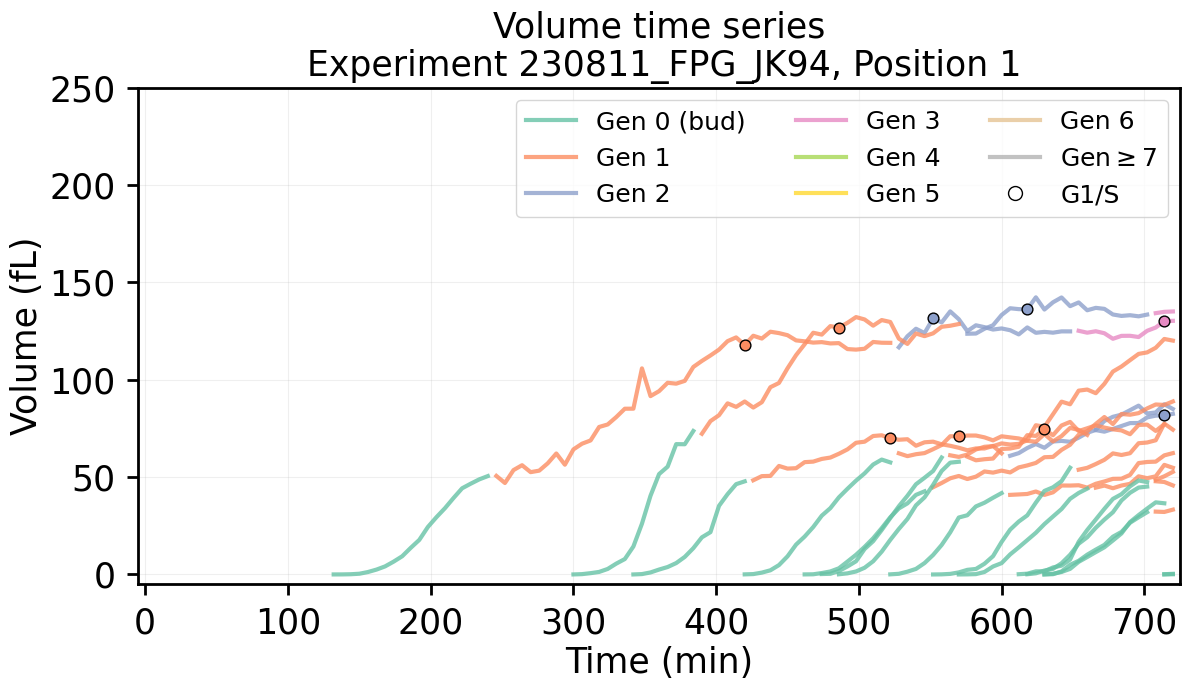

In [18]:
cmap = mpl.colormaps['Set2']
n = 8
values = np.linspace(0, 1, n)
colors = cmap(values)

f, ax = plt.subplots(1,1,figsize=(12,7),tight_layout=0)
ax = set_axes(ax)
for ID in analysis_dict.keys():
    ID_dict = analysis_dict[ID]
    for gen in ID_dict.keys():
        gen_dict = ID_dict[gen]
        time, vol = gen_dict['Time'], gen_dict['Volume']
        c = colors[min(int(gen[-1]),n-1)]
        ax.plot(time,vol,color=c,lw=3,alpha=0.8)
        
        if 'Volume_G1_S' in gen_dict.keys():
            v_g1_s = gen_dict['Volume_G1_S']
            t_g1_s = gen_dict['Time_G1_S']
            ax.scatter(t_g1_s,v_g1_s,facecolor=c,edgecolor='k',lw=1,s=60,zorder=4)

handles, labels = plt.gca().get_legend_handles_labels()
for i in range(n):
    if i == 0:
        line = Line2D([0], [0], label='Gen 0 (bud)', color=colors[i],lw = 3,alpha=0.8)
    elif i == n-1:
        line = Line2D([0], [0], label=r'Gen$\geq$'+str(i),color=colors[i],lw = 3,alpha=0.8)
    else:
        line = Line2D([0], [0], label='Gen '+str(i), color=colors[i],lw = 3,alpha=0.8)
    handles.append(line)

# create manual symbols for legend
point = Line2D([0], [0], label='G1/S', marker='o', markersize=10, 
         markeredgecolor='k', markerfacecolor='w', linestyle='')
handles.append(point)
plt.legend(handles=handles,ncols=3,fontsize = 18)            
ax.set_xlabel('Time (min)',fontsize = ax_fontdict['size'])
ax.set_xlim([-5,120*6+5])
ax.set_ylabel('Volume (fL)',fontsize = ax_fontdict['size'])
ax.set_yticks(np.arange(0,300,50))
ax.set_ylim([-5,250])
ax.set_title('Volume time series\n Experiment '+experiment+', Position '+position
            ,fontsize = ax_fontdict['size']
            ,pad = ax_fontdict['pad'])
plt.grid(alpha=0.2,zorder=1)

plt.savefig(save_path+'/volume_time_series.png',dpi=450)
plt.show()

## Combine _all_ positions for an experiment and plot population statistics

Select the experiment you would like to load.

In [22]:
experiment = "230811_FPG_JK94" 
#Choices include "230811_FPG_JK94","230822_JX_JK93", "230823_FPG_JK93", "230830_FPG_JK94"

In [23]:
if experiment == "230811_FPG_JK94":
    max_pos = 9
elif experiment == "230822_JX_JK93":
    max_pos = 8
elif experiment == "230823_FPG_JK93":
    max_pos = 11
elif experiment == "230830_FPG_JK94":
    max_pos = 7
elif experiment == "210120_Yagya_WT":
    max_pos = 6
else:
    max_pos = 1
framerate = 6
window = 3
first_gen_vol_g1_s = []
first_gen_vol_birth = []
first_gen_g1_growth = [[],[]]
fg_vg1s_relgen = {}

daughter_g1_length = []
mother_g1_length = []
mother_vol_birth = []
mother_vol_g1_s = []

end_vol = []
end_gen = []
end_cc = []

# V_n, V_n+1, age(n)
return_map = [[],[],[]]

print('Experiment: '+experiment+'\n')
analysis_dict = {}
for pos in range(1,max_pos+1):
    print('Position: '+str(pos))
    
    if experiment == "230823_FPG_JK93":
        if pos < 10:
            load_path = glob.glob(os.path.join("Movies",experiment,"Position_"+str(pos),experiment+"_pos*_g_s0"+str(pos)+"_acdc_output.csv"))[0]
        else:
            load_path = glob.glob(os.path.join("Movies",experiment,"Position_"+str(pos),experiment+"_pos*_g_s"+str(pos)+"_acdc_output.csv"))[0]
    else:
        load_path = glob.glob(os.path.join("Movies",experiment,"Position_"+str(pos),experiment+"_pos*_g_s"+str(pos)+"_acdc_output.csv"))[0]
    
    master_df = pd.read_csv(load_path)
    relevant_columns = ["frame_i","time_minutes","Cell_ID","cell_area_um2","cell_cycle_stage","cell_vol_fl",
                       "division_frame_i","emerg_frame_i","generation_num","is_cell_dead","is_cell_excluded",
                       "is_history_known","relationship","relative_ID"]
    filtered_df = master_df.loc[:, relevant_columns]

    IDS = np.unique(np.array(filtered_df["Cell_ID"]))
    analysis_dict['Position_'+str(pos)] = {} #This is the nested analysis dictionary

    for i,ID in enumerate(IDS):
        # Loop over each unique cell ID
        analysis_dict['Position_'+str(pos)]['Cell_'+str(ID)] = {} # Add an item in the dict. for each ID
        gen_num = np.unique(filtered_df[filtered_df.Cell_ID == ID]["generation_num"]) # Get each generation for each ID
        
        for gen in gen_num:
            # Loop over each unique generation number. If == 0, it's a bud. 

            temp_df = filtered_df[(filtered_df.Cell_ID == ID) & (filtered_df.generation_num == gen)]
            if np.array(temp_df["is_cell_excluded"])[0] == 1 or np.array(temp_df["is_cell_dead"])[0] == 1 or np.array(temp_df["is_history_known"])[0] == 0:
                continue
            # For each ID and Generation, we get the time, volume and cell cycle stage series.
            vol = np.array(temp_df["cell_vol_fl"])
            time = np.array(temp_df["time_minutes"])
            cc = np.array(temp_df["cell_cycle_stage"])
            
            g1 = np.where(cc == 'G1')[0]
            # Is the cell in G1? Record the initial size V(t_i) and the subsequent growth in 
            # the time frame \Delta V = V(t_i+1) - V(t_i) to estimate the G1 growth rate
            if len(g1) > 2*np.floor(window/2) and gen == 1:
                smooth_vol_g1 = np.convolve(vol[g1], np.ones(window)/window, mode='valid')
                first_gen_g1_growth[0].extend(smooth_vol_g1[:-1])
                first_gen_g1_growth[1].extend(np.diff(smooth_vol_g1))

            rel_ID_at_birth = np.array(temp_df["relative_ID"])[0]
            rel_ID =  np.array(temp_df["relative_ID"])
            
            # Add these to the dict. 
            analysis_dict['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)] = {'Time':time,'Volume':vol,'Cell_cycle':cc,'Rel_ID_at_birth':rel_ID_at_birth,'Rel_ID':rel_ID}

            # Now we will extract specific values corresponding to birth, G1/S and division for each cell and each gen.
            vol_birth = vol[0]
            time_birth = time[0]
            analysis_dict['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_birth'] = vol_birth
            analysis_dict['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Time_birth'] = time_birth
            
            flag = 0
            flag2 = 0
            
            for j, jcc in enumerate(cc):
                if np.array(temp_df["is_cell_excluded"])[j] == 1 or np.array(temp_df["is_cell_dead"])[j] == 1 or np.array(temp_df["is_history_known"])[j] == 0:
                    continue
                
                g1_s = np.where(cc == 'S')[0]
                
                # Has the cell undergone G1/S transition 
                if len(g1_s) != 0 and gen != 0:
                    true_g1_s = g1_s[0]
                    vol_g1_s = vol[true_g1_s]
                    time_g1_s = time[true_g1_s] #Time since beginning of the generation
                    g1_length = time_g1_s - time_birth

                    analysis_dict['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_G1_S'] = vol_g1_s
                    analysis_dict['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Time_G1_S'] = time_g1_s
                    analysis_dict['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['G1_length'] = g1_length
                    if gen == 1 and flag == 0:
                        first_gen_vol_g1_s.append(vol_g1_s)
                        daughter_g1_length.append(g1_length)
                        first_gen_vol_birth.append(vol_birth)
                        #if g1_length >= 200:
                            #print('Long G1, ID: ',ID,', Position: ',pos,', Frame birth = ',time_birth/6)
                        
                        flag = 1
                    elif gen > 1 and flag2 == 0:
                        mother_g1_length.append(g1_length)
                        mother_vol_birth.append(vol_birth)
                        mother_vol_g1_s.append(vol_g1_s)
                        #print('Mother',vol_g1_s,', Gen',gen,', ID',ID)
                        flag2 = 1

                # Has the cell divided before the last frame? 
                if gen != gen_num[-1] and gen != 0:
                    time_div = time[-1]
                    vol_div = vol[-1]
                    sg2m_length = time_div - time_g1_s

                    analysis_dict['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_division'] = vol_div
                    analysis_dict['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Time_division'] = time_div
                    analysis_dict['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['SG2M_length'] = sg2m_length

                # Last frame steady-state volumes
                if gen == gen_num[-1] and j == len(cc)-1:

                    vol_last_frame = vol[-1]
                    analysis_dict['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_last'] = vol_last_frame  
                    analysis_dict['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Cell_cycle_last'] = jcc

                    #Add bud volume to mother cell body
                    if gen == 0:
                        relative_ID = np.array(filtered_df[(filtered_df.Cell_ID == ID) & (filtered_df.generation_num == gen)]["relative_ID"])[0]
                        relative_gen_num = np.unique(filtered_df[filtered_df.Cell_ID == relative_ID]["generation_num"])
                        if 'Generation_'+str(relative_gen_num[-1]) in analysis_dict['Position_'+str(pos)]['Cell_'+str(relative_ID)].keys():
                            analysis_dict['Position_'+str(pos)]['Cell_'+str(relative_ID)]['Generation_'+str(relative_gen_num[-1])]['Volume_last'] += vol_last_frame
                        else:
                            continue

    for i,ID in enumerate(analysis_dict['Position_'+str(pos)].keys()):
        for j,gen in enumerate(analysis_dict['Position_'+str(pos)][ID].keys()):
            if 'Volume_last' in analysis_dict['Position_'+str(pos)][ID][gen] and gen[-1] != "0":
                #if analysis_dict[ID][gen]['Volume_last'] < 20:
                    #print(ID,gen,analysis_dict[ID][gen]['Volume_last'])
                end_vol.append(analysis_dict['Position_'+str(pos)][ID][gen]['Volume_last'])
                end_gen.append(int(gen[-1]))
                end_cc.append(analysis_dict['Position_'+str(pos)][ID][gen]['Cell_cycle_last'])
                
    for i,ID in enumerate(analysis_dict['Position_'+str(pos)].keys()):
        for j,gen in enumerate(analysis_dict['Position_'+str(pos)][ID].keys()):
            # Not a bud, not the last generation and has gone through G1/S
            if j != 0 and 'Generation_'+str(j+1) in analysis_dict['Position_'+str(pos)][ID].keys() and 'Volume_G1_S' in analysis_dict['Position_'+str(pos)][ID]['Generation_'+str(j+1)].keys():
                #V_n
                #print(ID,gen)
                #print(ID,gen,analysis_dict['Position_'+str(pos)][ID][gen].keys())
                return_map[0].append(analysis_dict['Position_'+str(pos)][ID][gen]['Volume_G1_S'])
                #V_n+1
                return_map[1].append(analysis_dict['Position_'+str(pos)][ID]['Generation_'+str(j+1)]['Volume_G1_S'])
                # Gen(n)
                return_map[2].append(j)
    
               
    for i,ID in enumerate(analysis_dict['Position_'+str(pos)].keys()):
        for j,gen in enumerate(analysis_dict['Position_'+str(pos)][ID].keys()):
            if gen == "Generation_1" and 'Time_G1_S' in analysis_dict['Position_'+str(pos)][ID][gen].keys():
                # Identify the first gen daughter cell that will go through G1/S in its cycle.
                # Record the time of birth and the relative ID.
                temp_time_birth = analysis_dict['Position_'+str(pos)][ID][gen]['Time_birth']
                rel_ID = analysis_dict['Position_'+str(pos)][ID][gen]['Rel_ID_at_birth']
                # Loop through the generations of the relative ID
                for rel_gen in analysis_dict['Position_'+str(pos)]['Cell_'+str(rel_ID)].keys():
                    # Identify the corresponding generation
                    # Not every 1st gen cells will have a corresponding relative whose history is known, so 
                    # sample size of first_gen_vol_g1_s_rel is smaller than first_gen_vol_g1_s
                    temp_rel_df = filtered_df[(filtered_df.Cell_ID == int(rel_ID)) & (filtered_df.generation_num == int(rel_gen[-1])-1)]
                    if np.any(np.array(temp_rel_df["is_cell_excluded"]) == 1) or np.any(np.array(temp_rel_df["is_cell_dead"]) == 1) or np.any(np.array(temp_rel_df["is_history_known"]) == 0):
                        # Is the history of the parent known? If not, skip it. Otherwise, record information.
                        continue
                    elif temp_time_birth == analysis_dict['Position_'+str(pos)]['Cell_'+str(rel_ID)][rel_gen]["Time_birth"]:
                        # Here we identify the rel_gen corresponding to the time of birth of the 1st gen daughter cell birth
                        # Record previous generation
                        if 'Generation_'+str(int(rel_gen[-1])-1) not in fg_vg1s_relgen.keys():
                            fg_vg1s_relgen['Generation_'+str(int(rel_gen[-1])-1)] = {}
                            fg_vg1s_relgen['Generation_'+str(int(rel_gen[-1])-1)]['Volume_G1_S'] = []
                            fg_vg1s_relgen['Generation_'+str(int(rel_gen[-1])-1)]['Mother_volume_G1_S'] = []
                        # Add the 1st gen daughter vol at G1/S conditioned on the mother's relative gen 
                        fg_vg1s_relgen['Generation_'+str(int(rel_gen[-1])-1)]['Volume_G1_S'].append(analysis_dict['Position_'+str(pos)][ID][gen]['Volume_G1_S'])
                        # Add the mother volume conditioned on its age
                        fg_vg1s_relgen['Generation_'+str(int(rel_gen[-1])-1)]['Mother_volume_G1_S'].append(analysis_dict['Position_'+str(pos)]['Cell_'+str(rel_ID)]['Generation_'+str(int(rel_gen[-1])-1)]['Volume_G1_S'])

agg = 1
if agg == 1:
    subhist=[[],[]]
    mother_subhist=[[],[]]
    
    for i,rel_gen in enumerate(fg_vg1s_relgen.keys()):
        if i == 0:
            subhist[0].extend(fg_vg1s_relgen[rel_gen]['Volume_G1_S'])
            mother_subhist[0].extend(fg_vg1s_relgen[rel_gen]['Mother_volume_G1_S'])
        else:
            subhist[1].extend(fg_vg1s_relgen[rel_gen]['Volume_G1_S'])
            mother_subhist[1].extend(fg_vg1s_relgen[rel_gen]['Mother_volume_G1_S'])
else:
    subhist = []
    mother_subhist = []
    for i,rel_gen in enumerate(fg_vg1s_relgen.keys()):
        subhist.append([])
        subhist[i].extend(fg_vg1s_relgen[rel_gen]['Volume_G1_S'])
        mother_subhist[i].extend(fg_vg1s_relgen[rel_gen]['Mother_volume_G1_S'])

Experiment: 230811_FPG_JK94

Position: 1
Position: 2
Position: 3
Position: 4
Position: 5
Position: 6
Position: 7
Position: 8
Position: 9


___
## 1st. gen G1 growth rate estimate
This uses **smoothed cell volumes** in G1 using a rolling average with a window correspondg to the `window` notebook variable in the processing step. Window should be as small as possible, ideally 3, or else we overestimate volume. 

If cells grow exponentially, the interframe growth rate should be linearily increasing with cell volumes and we recover the absolute growth rate $\lambda = \frac{1}{\Delta t}\log(slope +1)$.
___

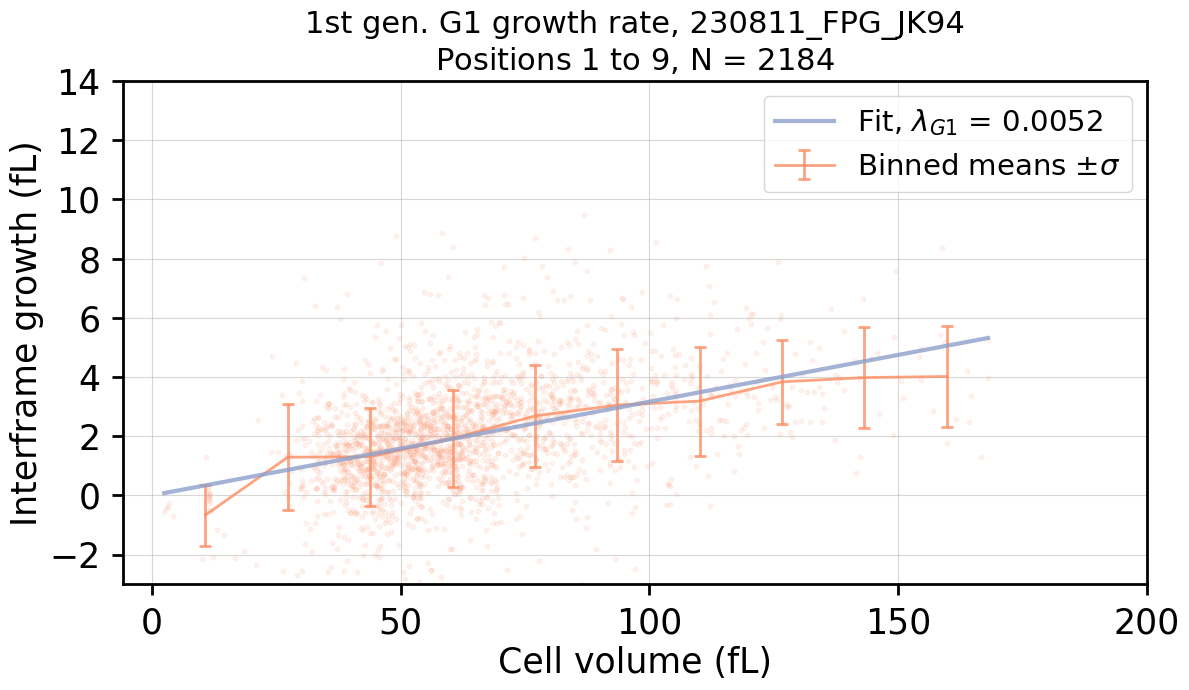

In [24]:
X, Y = np.array(first_gen_g1_growth[0]).reshape(-1,1),np.array(first_gen_g1_growth[1]).reshape(-1,1)

regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(X,Y)

# Make predictions using the testing set
x_plot = np.linspace(np.amin(X),np.amax(X),50).reshape(-1,1)
y_plot = regr.predict(x_plot)
slope = regr.coef_[0][0]
#intercept = regr.intercept_[0]
score = regr.score(X, Y)
######
G1_growth_rate = np.log(slope+1)/framerate
# Binned Statistics 
n_bins = 10
bin_std, bin_edges, binnumber = stats.binned_statistic(first_gen_g1_growth[0],first_gen_g1_growth[1],statistic='std', bins=n_bins)
bin_means, bin_edges, binnumber = stats.binned_statistic(first_gen_g1_growth[0],first_gen_g1_growth[1],statistic='mean', bins=n_bins)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

f,ax = plt.subplots(1,1,figsize=(12,7),tight_layout=1)
ax = set_axes(ax)
ax.scatter(X,Y,s=10,color=colors[1],alpha=0.1,zorder=1)
ax.errorbar(bin_centers,bin_means,yerr=bin_std,capsize=4,capthick=2,c=colors[1],lw=2,zorder=2,alpha=0.8,label=r'Binned means $\pm \sigma$')  
ax.plot(x_plot,y_plot,c=colors[2],lw=3,alpha=0.8,zorder=3,label='Fit, $\lambda_{G1}$ = %.4f'%G1_growth_rate)
#ax.set_xlim([0,140])
ax.set_ylim(-3,10)

ax.set_ylabel('Interframe growth (fL)',fontsize = ax_fontdict['size'])
ax.set_yticks([-2,0,2,4,6,8,10,12,14])
ax.set_xlabel('Cell volume (fL)',fontsize = ax_fontdict['size'])
ax.set_xticks(np.arange(0,250,50))
plt.grid(alpha=0.5,zorder=1)

ax.set_title('1st gen. G1 growth rate, %s\n'%experiment+r'Positions 1 to %i, $\rm N$ = %i'%(max_pos,len(X))
             ,fontsize = ax_fontdict['size']-3,pad=ax_fontdict['pad'])
plt.legend(fontsize = ax_fontdict['size']-4,ncol=1)
#plt.savefig(os.path.join("Experiments",experiment,'first_gen_g1_growth_rate_smoothwindow_%i.png'%window),dpi=450)
plt.show()

___
## Plot 1st. gen cells volume at G1/S transition
___ 

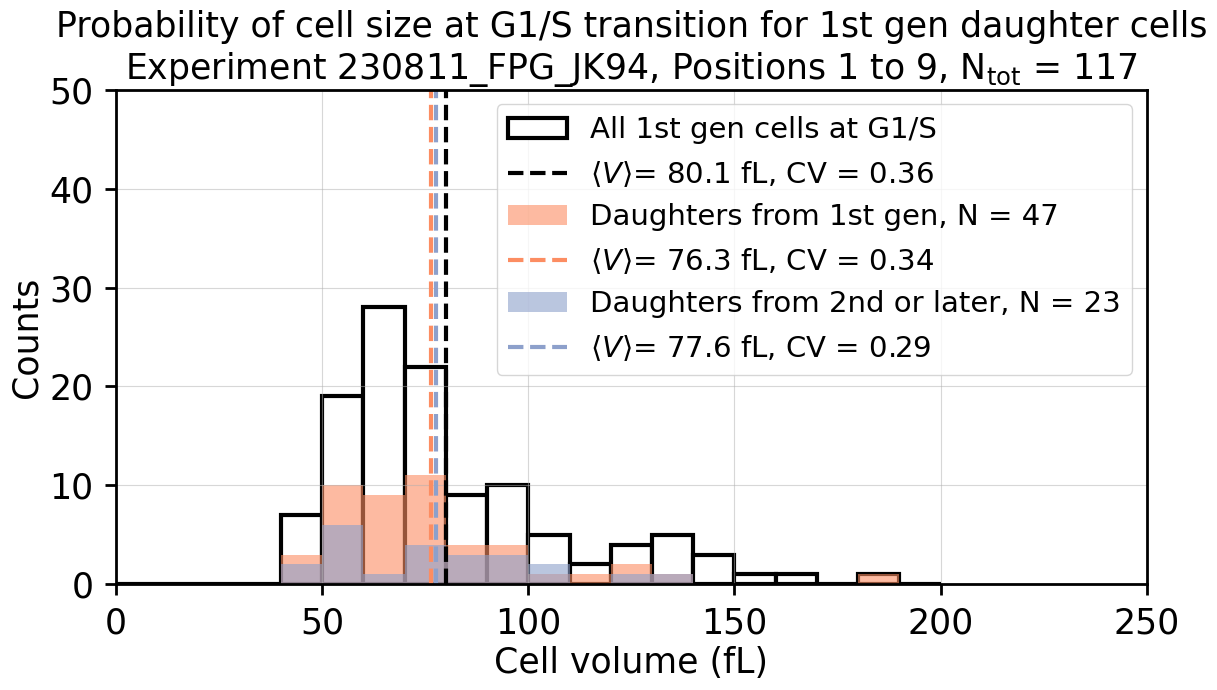

In [25]:
ncell = len(first_gen_vol_g1_s)

bs=10
bs_rel = 5
bins = np.arange(0,201,bs)
bins_rel = np.arange(0,201,bs_rel)
x_plot = np.arange(0,201,1)

bw=10
kde = KernelDensity(kernel='gaussian',bandwidth=bw).fit(np.array(first_gen_vol_g1_s).reshape(-1,1))
log_dens = kde.score_samples(x_plot.reshape(-1,1))

mean_vol_g1_s = np.mean(first_gen_vol_g1_s)
std_vol_g1_s = np.std(first_gen_vol_g1_s)
cv_vol_g1_s = std_vol_g1_s/mean_vol_g1_s

f, ax = plt.subplots(1,1,figsize=(12,7),tight_layout=1)
ax = set_axes(ax)

plt.hist(first_gen_vol_g1_s,bins=bins,density=0,facecolor='w',edgecolor='k',lw=3,alpha=1,label='All 1st gen cells at G1/S')
ax.axvline(mean_vol_g1_s,ls='--',lw=3,color='k',label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(mean_vol_g1_s,cv_vol_g1_s))

if agg == 1:
    for i in range(len(subhist)):
        if i == 0:
            plt.hist(subhist[i],bins=bins,density=0,facecolor=colors[1],edgecolor=colors[1],lw=0,alpha=0.6,label='Daughters from 1st gen, N = %i'%len(subhist[i]))
            sub_mean_vol_g1_s = np.mean(subhist[i])
            sub_std_vol_g1_s = np.std(subhist[i])
            sub_cv_vol_g1_s = sub_std_vol_g1_s/sub_mean_vol_g1_s
            ax.axvline(sub_mean_vol_g1_s,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_g1_s,sub_cv_vol_g1_s))
        else:
            plt.hist(subhist[i],bins=bins,density=0,facecolor=colors[2],edgecolor=colors[2],lw=0,alpha=0.6,label='Daughters from 2nd or later, N = %i'%len(subhist[i]))
            sub_mean_vol_g1_s = np.mean(subhist[i])
            sub_std_vol_g1_s = np.std(subhist[i])
            sub_cv_vol_g1_s = sub_std_vol_g1_s/sub_mean_vol_g1_s
            ax.axvline(sub_mean_vol_g1_s,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_g1_s,sub_cv_vol_g1_s))
else:
    for i in range(len(subhist)):
        plt.hist(subhist[i],bins=bins,density=0,facecolor=colors[i+1],edgecolor=colors[i+1],lw=0,alpha=0.6,label='Born from %i gen cells, N = %i'%(int(i+1),len(subhist[i])))
        sub_mean_vol_g1_s = np.mean(subhist[i])
        sub_std_vol_g1_s = np.std(subhist[i])
        sub_cv_vol_g1_s = sub_std_vol_g1_s/sub_mean_vol_g1_s
        ax.axvline(sub_mean_vol_g1_s,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_g1_s,sub_cv_vol_g1_s))


ax.set_xlim([0,250])
ax.set_ylim([0,50])
ax.set_ylabel('Counts',fontsize = ax_fontdict['size'])
#ax.set_yticks([0,0.01,0.02,0.03,0.04])
ax.set_xlabel('Cell volume (fL)',fontsize = ax_fontdict['size'])
plt.grid(alpha=0.5,zorder=1)

ax.set_title('Probability of cell size at G1/S transition for 1st gen daughter cells\n'+r'Experiment %s, Positions 1 to %i, $\rm N_{tot}$ = %i'%(experiment,max_pos,ncell)
             ,fontsize = ax_fontdict['size'],pad=ax_fontdict['pad'])

plt.legend(fontsize = ax_fontdict['size']-4,ncol=1)

#plt.savefig(os.path.join("Experiments",experiment,'size_first_gen_daughter_g1_s_subpopulations.png'),dpi=450)
plt.show()

___
### SUBFIGURE : Mother volume at G1/S for the subpopulations identified in the previous plot
___

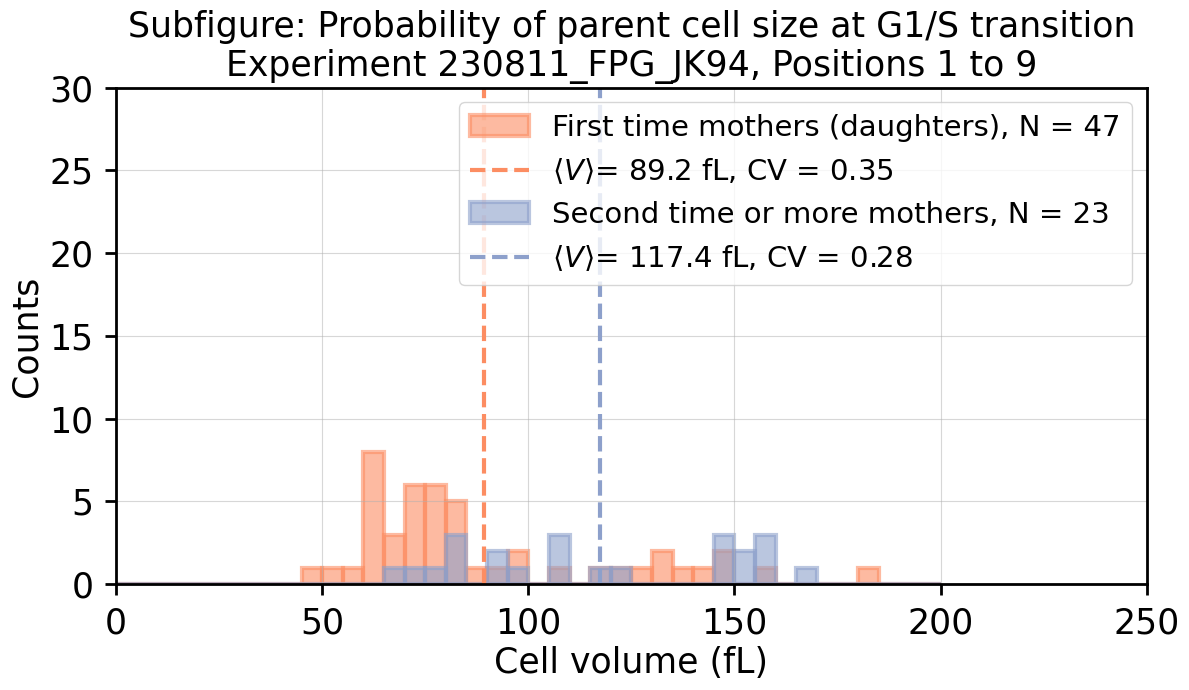

In [26]:
ncell = len(mother_vol_g1_s)

bs=5
bs_rel = 5
bins = np.arange(0,201,bs)
bins_rel = np.arange(0,201,bs_rel)
x_plot = np.arange(0,201,1)

bw=10
kde = KernelDensity(kernel='gaussian',bandwidth=bw).fit(np.array(mother_vol_g1_s).reshape(-1,1))
log_dens = kde.score_samples(x_plot.reshape(-1,1))

mean_vol_g1_s = np.mean(mother_vol_g1_s)
std_vol_g1_s = np.std(mother_vol_g1_s)
cv_vol_g1_s = std_vol_g1_s/mean_vol_g1_s

f, ax = plt.subplots(1,1,figsize=(12,7),tight_layout=1)
ax = set_axes(ax)

#plt.hist(mother_vol_g1_s,bins=bins,density=0,facecolor='w',edgecolor='k',lw=3,alpha=1,label='All > 2nd gen cells at G1/S')
#ax.axvline(mean_vol_g1_s,ls='--',lw=3,color='k',label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(mean_vol_g1_s,cv_vol_g1_s))

if agg == 1:
    for i in range(len(mother_subhist)):
        if i == 0:
            plt.hist(mother_subhist[i],bins=bins,density=0,facecolor=colors[1],edgecolor=colors[1],lw=3,alpha=0.6,label='First time mothers (daughters), N = %i'%len(subhist[i]))
            sub_mean_vol_g1_s = np.mean(mother_subhist[i])
            sub_std_vol_g1_s = np.std(mother_subhist[i])
            sub_cv_vol_g1_s = sub_std_vol_g1_s/sub_mean_vol_g1_s
            ax.axvline(sub_mean_vol_g1_s,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_g1_s,sub_cv_vol_g1_s))
        else:
            plt.hist(mother_subhist[i],bins=bins,density=0,facecolor=colors[2],edgecolor=colors[2],lw=3,alpha=0.6,label='Second time or more mothers, N = %i'%len(subhist[i]))
            sub_mean_vol_g1_s = np.mean(mother_subhist[i])
            sub_std_vol_g1_s = np.std(mother_subhist[i])
            sub_cv_vol_g1_s = sub_std_vol_g1_s/sub_mean_vol_g1_s
            ax.axvline(sub_mean_vol_g1_s,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_g1_s,sub_cv_vol_g1_s))
else:
    for i in range(len(subhist)):
        plt.hist(mother_subhist[i],bins=bins,density=0,facecolor=colors[i+1],edgecolor=colors[i+1],lw=3,alpha=0.6,label='%i-th time mothers, N = %i'%(int(i+1),len(subhist[i])))
        sub_mean_vol_g1_s = np.mean(mother_subhist[i])
        sub_std_vol_g1_s = np.std(mother_subhist[i])
        sub_cv_vol_g1_s = sub_std_vol_g1_s/sub_mean_vol_g1_s
        ax.axvline(sub_mean_vol_g1_s,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_g1_s,sub_cv_vol_g1_s))


ax.set_xlim([0,250])
ax.set_ylim([0,30])
ax.set_ylabel('Counts',fontsize = ax_fontdict['size'])
#ax.set_yticks([0,0.01,0.02,0.03,0.04])
ax.set_xlabel('Cell volume (fL)',fontsize = ax_fontdict['size'])
plt.grid(alpha=0.5,zorder=1)

ax.set_title('Subfigure: Probability of parent cell size at G1/S transition\n'+r'Experiment %s, Positions 1 to %i'%(experiment,max_pos)
             ,fontsize = ax_fontdict['size'],pad=ax_fontdict['pad'])

plt.legend(fontsize = ax_fontdict['size']-4,ncol=1)

#plt.savefig(os.path.join("Experiments",experiment,'parentsize_first_gen_daughter_g1_s_subpopulations.png'),dpi=450)
plt.show()

## Return map of the G1/S volume of generation N+1 as a function of G1/S volume of generation N conditioned on the age of generation N.

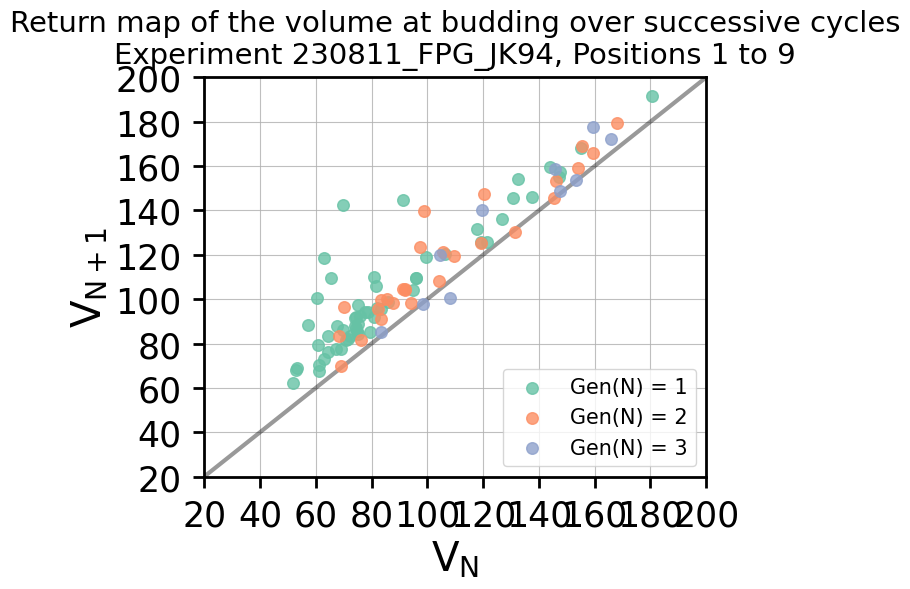

In [28]:
x_plot = np.arange(20,211,1)
mean_size = np.mean(first_gen_vol_g1_s)
y_timer = x_plot
#y_adder = 
#y_sizer = 


f, ax = plt.subplots(1,1,figsize=(7,6),tight_layout=1)
ax1 = set_axes(ax)

for gen in range(10):
    gen_indices = np.where(np.array(return_map[2])==gen)
    if len(gen_indices[0]) == 0:
        continue
    V_n = np.array(return_map[0])[gen_indices]
    V_np1 = np.array(return_map[1])[gen_indices]
    ax1.scatter(V_n,V_np1,s=70,color=colors[gen-1],alpha=0.8,zorder=3,label='Gen(N) = %i'%gen)
    
ax1.plot(x_plot,y_timer,c='k',lw=3,alpha=0.4,zorder=2)

ax1.set_xlabel(r'$\rm V_{N}$',fontsize=ax_fontdict['size']+4)
ax1.set_ylabel(r'$\rm V_{N+1}$',fontsize=ax_fontdict['size']+4)

ax1.set_xticks(np.arange(0,201,20))
ax1.set_yticks(np.arange(0,201,20))
ax1.set_xlim([20,200])
ax1.set_ylim([20,200])

ax1.legend(loc='lower right',fontsize=ax_fontdict['size']-10,ncol=1)

ax1.grid(axis='both',alpha=0.8,zorder=1)

ax1.set_title('Return map of the volume at budding over successive cycles\nExperiment %s, Positions 1 to %i'%(experiment,max_pos),
              fontsize=ax_fontdict['size']-4, pad = 10)

#plt.savefig(os.path.join("Experiments",experiment,'return_map_volume_g1_s.png'),dpi=450)
plt.show()


## Box plots of the G1/S cell size for different generations

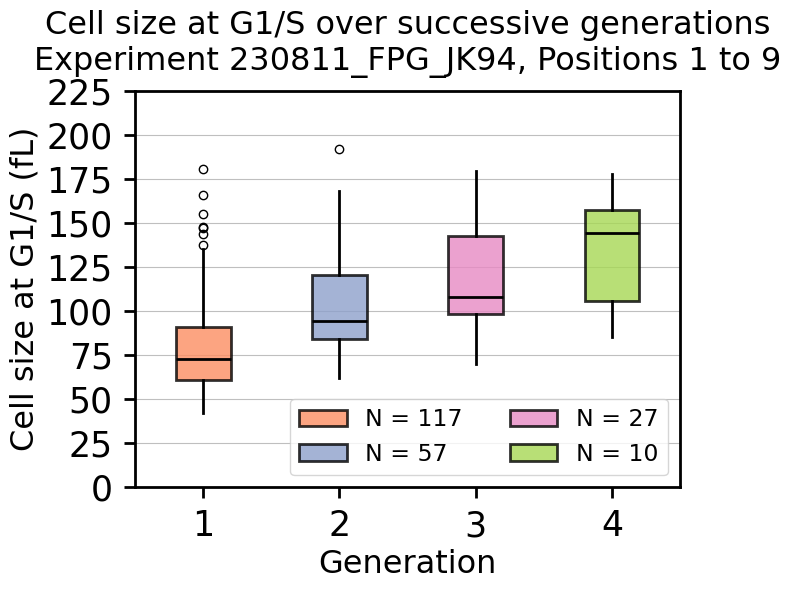

In [29]:

vg1s_all = {}

for pos in range(1,max_pos+1):
    for i,ID in enumerate(analysis_dict['Position_'+str(pos)].keys()):
        for j,gen in enumerate(analysis_dict['Position_'+str(pos)][ID].keys()):
            if gen not in vg1s_all.keys():
                vg1s_all[gen] = []
                
            if 'Volume_G1_S' in analysis_dict['Position_'+str(pos)][ID][gen].keys():
                vg1s_all[gen].append(analysis_dict['Position_'+str(pos)][ID][gen]['Volume_G1_S'])

f, ax  = plt.subplots(1,1,figsize=(7,6),tight_layout=1)
ax = set_axes(ax)

bp_label = []
bp_patch = []
for igen,gen in enumerate(vg1s_all.keys()):
    ncell = len(vg1s_all[gen])
    if ncell > 5:
        globals()['bp'+str(igen)] = ax.boxplot(vg1s_all[gen],positions=[igen],vert=True,widths=0.4,showfliers=1,showmeans=0,showcaps=0,
            patch_artist=True,boxprops=dict(facecolor=colors[igen],color='k',alpha=0.8,lw=2),
             medianprops = dict(color='k',lw=2),whiskerprops = dict(color='k',lw=2))
        bp_label.append(('N = '+str(ncell)))
        bp_patch.append(mpl.patches.Patch(facecolor=colors[igen],alpha=0.8,edgecolor='k',lw=2,))        
ax.legend(bp_patch,bp_label,loc='best',fontsize=ax_fontdict['size']-8,ncol=2)

ax.set_ylabel('Cell size at G1/S (fL)',fontsize = ax_fontdict['size']-2)
ax.set_xlabel('Generation',fontsize = ax_fontdict['size']-2)
ax.set_yticks(np.arange(0,301,25))
ax.set_ylim(0,225)
ax.set_title('Cell size at G1/S over successive generations\nExperiment %s, Positions 1 to %i'%(experiment,max_pos),fontsize=ax_fontdict['size']-2,pad=15)
ax.grid(axis='y',alpha=0.8)

#plt.savefig(os.path.join("Experiments",experiment,'volume_g1_s_generations_boxplot.png'),dpi=450)

plt.show()

## Added volume in G1 for first gen daughter cells

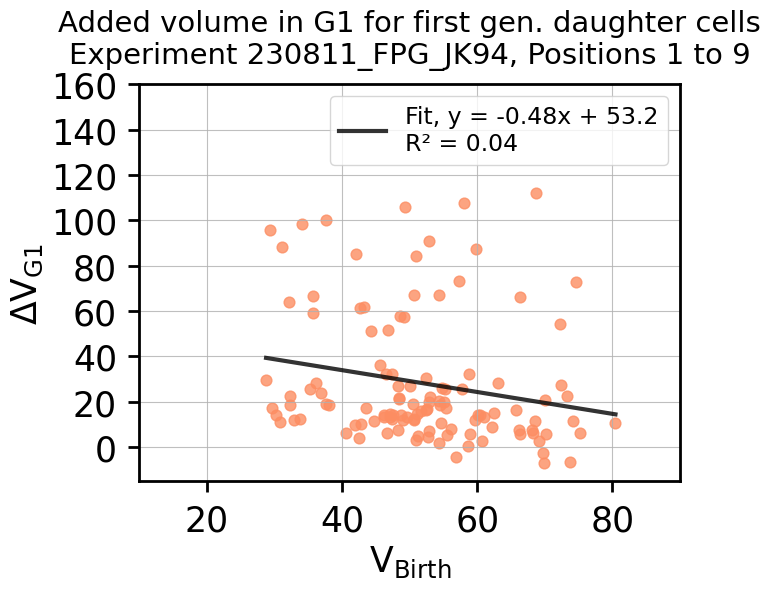

In [30]:
z_scores = (np.array(first_gen_vol_birth)-np.mean(first_gen_vol_birth))/np.std(first_gen_vol_birth)

mask = 0
z_thresh = 2
if mask:
    first_gen_vol_birth_plot = np.array(first_gen_vol_birth)[np.where(z_scores<z_thresh)]
    first_gen_vol_g1_s_plot = np.array(first_gen_vol_g1_s)[np.where(z_scores<z_thresh)]
else:
    first_gen_vol_birth_plot = np.array(first_gen_vol_birth)
    first_gen_vol_g1_s_plot = np.array(first_gen_vol_g1_s)
    
X = np.array(first_gen_vol_birth_plot).reshape(-1,1)
Y = np.array(first_gen_vol_g1_s_plot).reshape(-1,1) - np.array(first_gen_vol_birth_plot).reshape(-1,1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, Y)

# Make predictions using the testing set
x_plot = np.linspace(np.amin(X),np.amax(X))
y_plot = regr.predict(x_plot.reshape(-1,1))
slope = regr.coef_[0][0]
intercept = regr.intercept_[0]
score = regr.score(X,Y)

f,ax = plt.subplots(1,1,figsize=(7,6),tight_layout=1)
ax=set_axes(ax)

ax.scatter(X,Y,s=60,color=colors[1],alpha=0.8)
if mask:
    ax.scatter(np.array(first_gen_vol_birth)[np.where(z_scores>=z_thresh)],
               np.array(first_gen_vol_g1_s)[np.where(z_scores>=z_thresh)]-np.array(first_gen_vol_birth)[np.where(z_scores>=z_thresh)],
               facecolor="gray",alpha=0.4,edgecolor='k',s=80,zorder=1,label='Outliers, Z $\geq$ %s'%str(z_thresh))
ax.plot(x_plot,y_plot,lw=3,color='k',alpha=0.8,label='Fit, y = %.2fx + %.1f\nR² = %.2f'%(slope,intercept,score))

ax.set_xlabel(r'$\rm V_{Birth}$',fontsize=ax_fontdict['size'])
ax.set_ylabel(r'$\rm \Delta V_{G1}$',fontsize=ax_fontdict['size'])

ax.set_xticks(np.arange(0,101,20))
ax.set_yticks(np.arange(0,201,20))

ax.set_xlim(10,90)
ax.set_ylim(-15,160)

ax.set_title('Added volume in G1 for first gen. daughter cells\nExperiment %s, Positions 1 to %i'%(experiment,max_pos),
            fontsize=ax_fontdict['size']-4,pad=15)

plt.legend(fontsize=ax_fontdict['size']-8)
plt.grid(which='both',alpha=0.8)

#plt.savefig(os.path.join("Experiments",experiment,'added_volume_G1.png'),dpi=450)

plt.show()


## Time in G1 for first gen. daughter cells

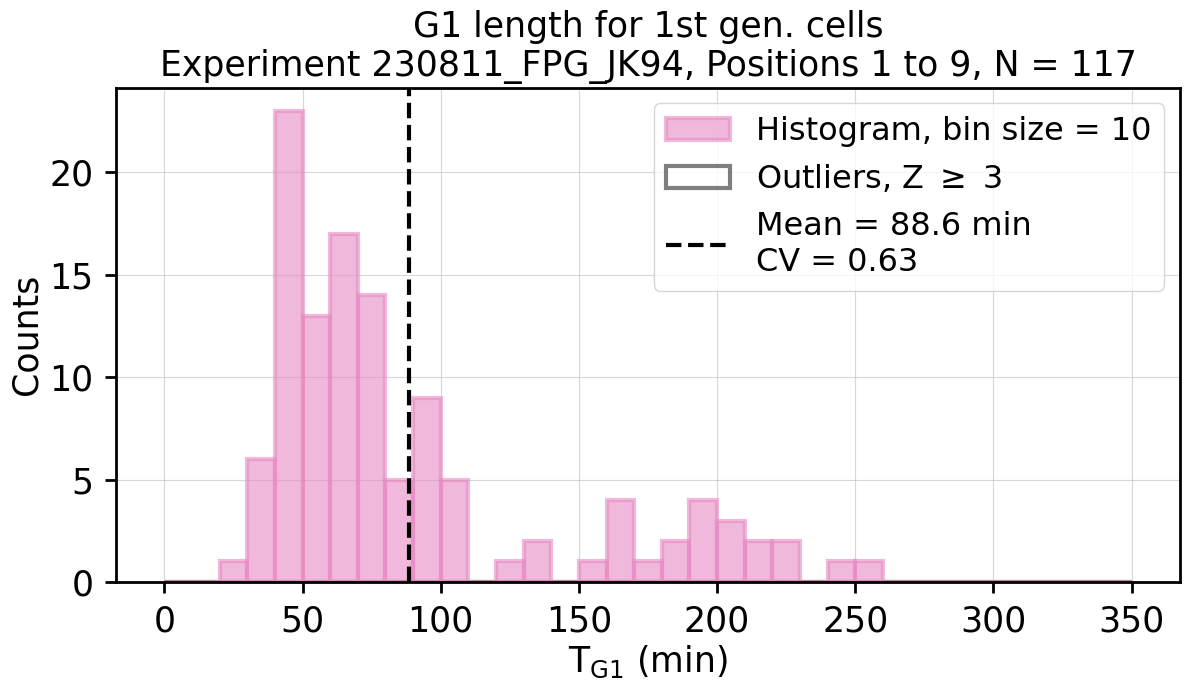

In [36]:
z_scores = (np.array(daughter_g1_length)-np.mean(daughter_g1_length))/np.std(daughter_g1_length)

mask = 1
z_thresh = 3
if mask:
    daughter_g1_length_plot = np.array(daughter_g1_length)[np.where(z_scores<z_thresh)]
else:
    daughter_g1_length_plot = np.array(daughter_g1_length)
ncell = len(daughter_g1_length_plot)


bs=10
bins = np.arange(0,351,bs)
x_plot = np.arange(0,351,1)

bw=10
kde = KernelDensity(kernel='gaussian',bandwidth=bw).fit(np.array(daughter_g1_length_plot).reshape(-1,1))
log_dens = kde.score_samples(x_plot.reshape(-1,1))

mean_daughter_g1_length = np.mean(daughter_g1_length_plot)
std_daughter_g1_length = np.std(daughter_g1_length_plot)
cv_daughter_g1_length = std_daughter_g1_length/mean_daughter_g1_length

f, ax = plt.subplots(1,1,figsize=(12,7),tight_layout=0)
ax = set_axes(ax)
if mask:
    plt.hist(daughter_g1_length_plot,bins=bins,density=0,facecolor=colors[3],edgecolor=colors[3],lw=3,alpha=0.6,zorder=2,label='Histogram, bin size = %i'%bs)
    plt.hist(np.array(daughter_g1_length)[np.where(z_scores>=z_thresh)],bins=bins,density=0,facecolor='w'
             ,edgecolor='k',lw=3,alpha=0.5,zorder=1,label=r'Outliers, Z $\geq$ %s'%str(z_thresh))

else:
    plt.hist(daughter_g1_length_plot,bins=bins,density=1,facecolor=colors[3],edgecolor=colors[3],lw=3,alpha=0.6,label='Histogram, bin size = %i'%bs)
ax.axvline(mean_daughter_g1_length,ls='--',lw=3,color='k',label='Mean = %.1f min \nCV = %.2f'%(mean_daughter_g1_length,cv_daughter_g1_length))
#ax.plot(x_plot.reshape(-1,1),np.exp(log_dens),lw=3,color='r',label='KDE, bw = %.f'%bw)

#ax.set_xlim([0,250])
#ax.set_ylim([0,0.03])
ax.set_ylabel('Counts',fontsize = ax_fontdict['size'])
#ax.set_yticks([0,0.01,0.02,0.03,0.04])
ax.set_xlabel(r'$\rm T_{G1}$ (min)',fontsize = ax_fontdict['size'])
plt.grid(alpha=0.5,zorder=1)

ax.set_title('G1 length for 1st gen. cells\nExperiment %s, Positions 1 to %i, N = %i'%(experiment,max_pos,ncell)
             ,fontsize = ax_fontdict['size'],pad=ax_fontdict['pad'])

plt.legend(fontsize = ax_fontdict['size']-2)
#if mask:
    #plt.savefig(os.path.join("Experiments",experiment,'g1_length_daughters_maskoutlier_zthresh_%s.png'%str(z_thresh)),dpi=450)
#else:
    #plt.savefig(os.path.join("Experiments",experiment,'g1_length_daughters.png'),dpi=450)
plt.show()

## Estimating cell size control in G1

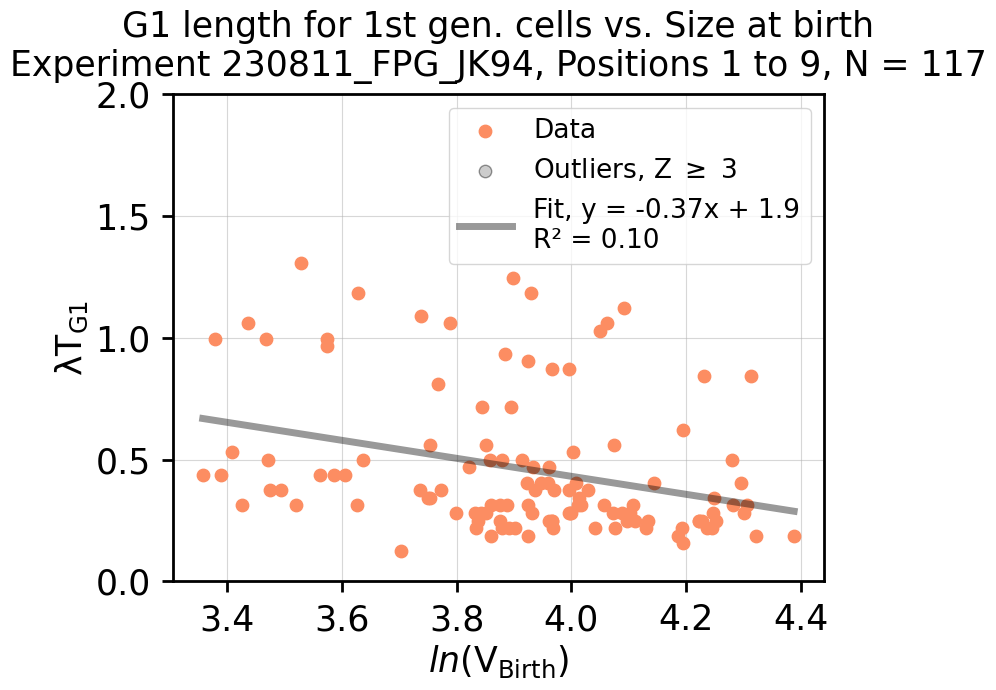

In [38]:
## GROWTH RATE
X, Y = np.array(first_gen_g1_growth[0]).reshape(-1,1),np.array(first_gen_g1_growth[1]).reshape(-1,1)
regr_gr = linear_model.LinearRegression(fit_intercept=False)
# Train the model using the training sets
regr_gr.fit(X,Y)
# Make predictions using the testing set
x_plot = np.linspace(np.amin(X),np.amax(X),50).reshape(-1,1)
y_plot = regr_gr.predict(x_plot)
slope = regr_gr.coef_[0][0]
#intercept = regr.intercept_[0]
score = regr_gr.score(X, Y)
######
G1_growth_rate = np.log(slope+1)/framerate

# LINEAR FIT T_G1 vs. log(V Birth)


mask = 1
z_thresh = 3
z_scores = (np.array(daughter_g1_length)-np.mean(daughter_g1_length))/np.std(daughter_g1_length)
if mask:
    daughter_g1_length_plot = np.array(daughter_g1_length)[np.where(z_scores<z_thresh)]
    first_gen_vol_birth_plot = np.array(first_gen_vol_birth)[np.where(z_scores<z_thresh)]
else:
    daughter_g1_length_plot = np.array(daughter_g1_length)
    first_gen_vol_birth_plot = np.array(first_gen_vol_birth)
    
ncell = len(daughter_g1_length_plot)

X, Y = np.log(first_gen_vol_birth_plot).reshape(-1,1), G1_growth_rate*np.array(daughter_g1_length_plot).reshape(-1,1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, Y)

# Make predictions using the testing set
x_plot = np.linspace(np.amin(X),np.amax(X))
y_plot = regr.predict(x_plot.reshape(-1,1))
slope = regr.coef_[0][0]
intercept = regr.intercept_[0]
score = regr.score(X,Y)


f, ax = plt.subplots(1,1,figsize=(8,7),tight_layout=1)
ax=set_axes(ax)

ax.scatter(X,Y,color=colors[1],s=80,zorder=2,label='Data')
if mask:
    ax.scatter(np.log(first_gen_vol_birth)[np.where(z_scores>=z_thresh)],
               G1_growth_rate*np.array(daughter_g1_length)[np.where(z_scores>=z_thresh)]
               ,facecolor="gray",alpha=0.4,edgecolor='k',s=80,zorder=1,label='Outliers, Z $\geq$ %s'%str(z_thresh))

ax.plot(x_plot,y_plot,lw=5,alpha=0.4,color='k',label='Fit, y = %.2fx + %.1f\nR² = %.2f'%(slope,intercept,score))
ax.set_ylabel(r'$\rm \lambda T_{G1}$',size = ax_fontdict['size'])
#ax.set_ylim(-25,375)
#ax.set_yticks([0,100,200,300])
ax.set_ylim(0,2)
#ax.set_xlim(2,4.8)
ax.set_xlabel(r'$ln(\rm V_{Birth})$',fontsize = ax_fontdict['size'])
plt.grid(alpha=0.5,zorder=1)

ax.set_title('G1 length for 1st gen. cells vs. Size at birth\nExperiment %s, Positions 1 to %i, N = %i'%(experiment,max_pos,ncell)
             ,fontsize = ax_fontdict['size'],pad=ax_fontdict['pad']+5)

plt.legend(fontsize = ax_fontdict['size']-6,loc='best',ncol=1)
plt.grid(alpha=0.5,zorder=1)
#if mask:
    #plt.savefig(os.path.join("Experiments",experiment,'lambda_g1_length_daughter_vs_size_birth_mask_zscore_%s.png'%str(z_thresh)),dpi=450)
#else:
    #plt.savefig(os.path.join("Experiments",experiment,'lambda_g1_length_daughter_vs_size_birth.png'),dpi=450)
plt.show()

## G1 length for 2nd generation or later mother cells. 

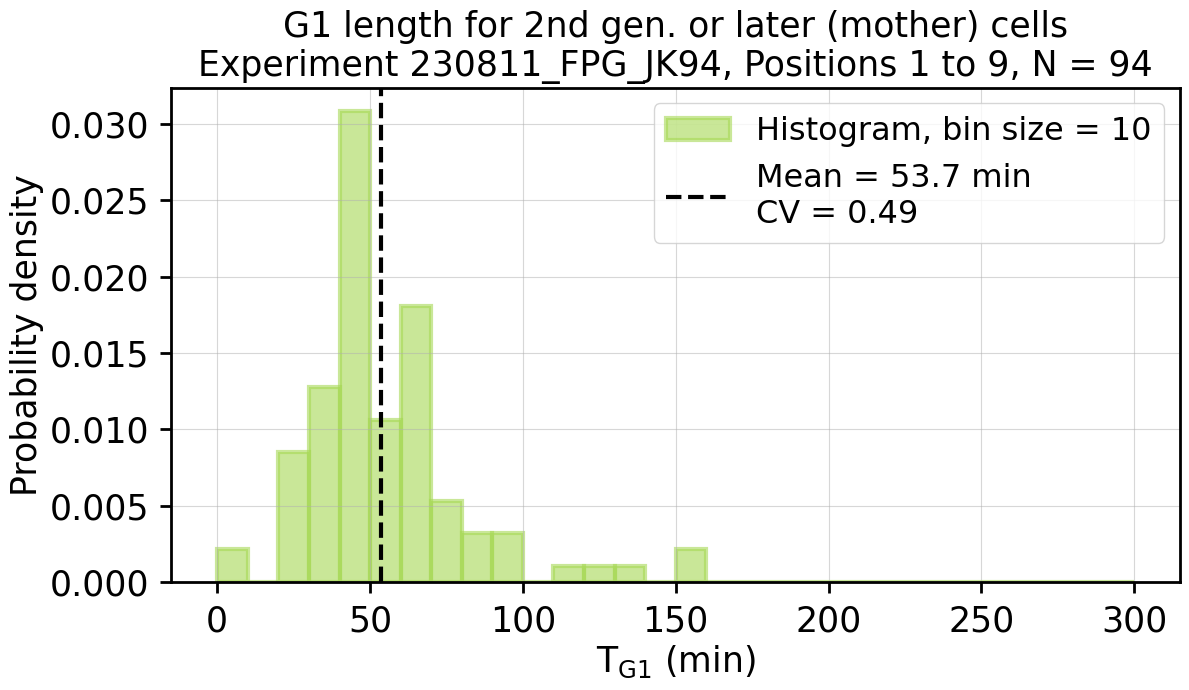

In [39]:
ncell = len(mother_g1_length)

bs=10
bins = np.arange(0,301,bs)
x_plot = np.arange(0,301,1)

bw=10
kde = KernelDensity(kernel='gaussian',bandwidth=bw).fit(np.array(mother_g1_length).reshape(-1,1))
log_dens = kde.score_samples(x_plot.reshape(-1,1))

mean_mother_g1_length = np.mean(mother_g1_length)
std_mother_g1_length = np.std(mother_g1_length)
cv_mother_g1_length = std_mother_g1_length/mean_mother_g1_length

f, ax = plt.subplots(1,1,figsize=(12,7),tight_layout=0)
ax = set_axes(ax)

plt.hist(mother_g1_length,bins=bins,density=1,facecolor=colors[4],edgecolor=colors[4],lw=3,alpha=0.6,label='Histogram, bin size = %i'%bs)
ax.axvline(mean_mother_g1_length,ls='--',lw=3,color='k',label='Mean = %.1f min \nCV = %.2f'%(mean_mother_g1_length,cv_mother_g1_length))
#ax.plot(x_plot.reshape(-1,1),np.exp(log_dens),lw=3,color='r',label='KDE, bw = %.f'%bw)

#ax.set_xlim([0,250])
#ax.set_ylim([0,0.03])
ax.set_ylabel('Probability density',fontsize = ax_fontdict['size'])
#ax.set_yticks([0,0.01,0.02,0.03,0.04])
ax.set_xlabel(r'$\rm T_{G1}$ (min)',fontsize = ax_fontdict['size'])
plt.grid(alpha=0.5,zorder=1)

ax.set_title('G1 length for 2nd gen. or later (mother) cells\nExperiment %s, Positions 1 to %i, N = %i'%(experiment,max_pos,ncell)
             ,fontsize = ax_fontdict['size'],pad=ax_fontdict['pad'])

plt.legend(fontsize = ax_fontdict['size']-2)

#plt.savefig(os.path.join("Experiments",experiment,'g1_length_mothers.png'),dpi=450)
plt.show()

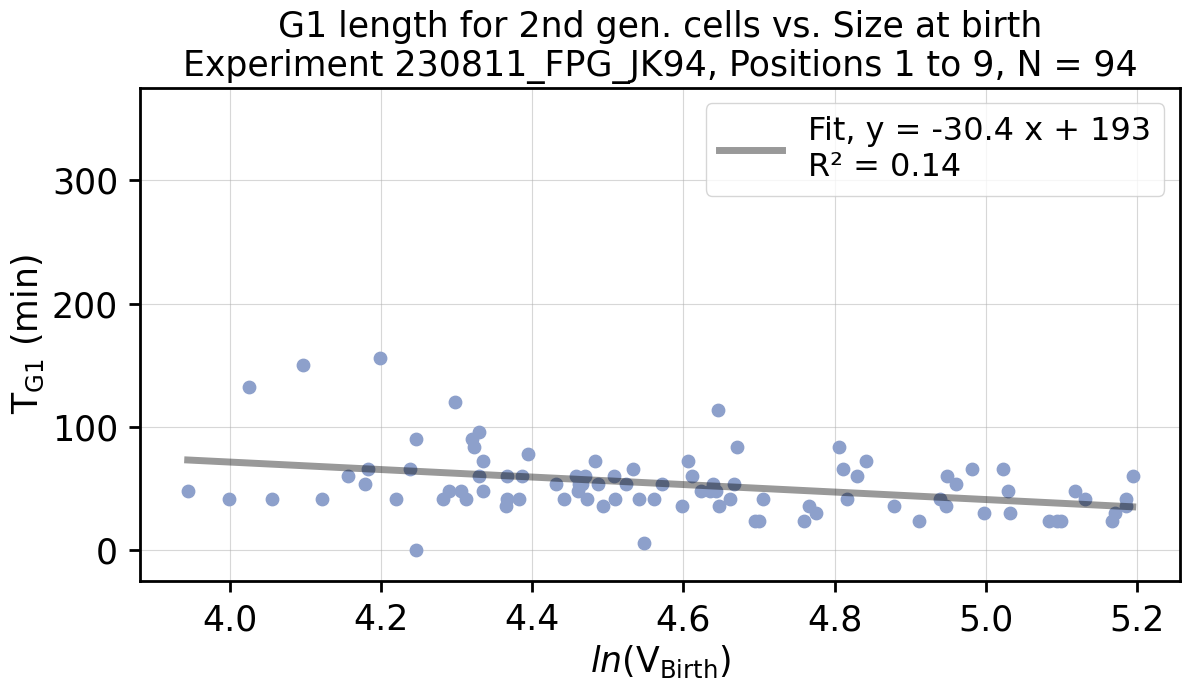

In [40]:
ncell = len(mother_g1_length)
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(np.log(mother_vol_birth).reshape(-1,1), np.array(mother_g1_length).reshape(-1,1))

# Make predictions using the testing set
x_plot = np.linspace(min(np.log(mother_vol_birth)),max(np.log(mother_vol_birth)),50).reshape(-1,1)
y_plot = regr.predict(x_plot)
slope = regr.coef_[0][0]
intercept = regr.intercept_[0]
score = regr.score(np.log(mother_vol_birth).reshape(-1,1),  np.array(mother_g1_length).reshape(-1,1))


f, ax = plt.subplots(1,1,figsize=(12,7),tight_layout=1)
ax=set_axes(ax)

ax.scatter(np.log(mother_vol_birth),mother_g1_length,color=colors[2],s=80,zorder=2)

ax.plot(x_plot,y_plot,lw=5,alpha=0.4,color='k',label='Fit, y = %.1f x + %.f\nR² = %.2f'%(slope,intercept,score))

ax.set_ylabel(r'$\rm T_{G1}$ (min)',size = ax_fontdict['size'])
ax.set_ylim(-25,375)
ax.set_yticks([0,100,200,300])
ax.set_xlabel(r'$ln(\rm V_{Birth})$',fontsize = ax_fontdict['size'])
plt.grid(alpha=0.5,zorder=1)

ax.set_title('G1 length for 2nd gen. cells vs. Size at birth\nExperiment %s, Positions 1 to %i, N = %i'%(experiment,max_pos,ncell)
             ,fontsize = ax_fontdict['size'],pad=ax_fontdict['pad'])

plt.legend(fontsize = ax_fontdict['size']-2)
plt.grid(alpha=0.5,zorder=1)

#plt.savefig(os.path.join("Experiments",experiment,'g1_length_mother_vs_size_birth.png'),dpi=450)
plt.show()

___
## Plot all cells volume at the last frame of the movies
___

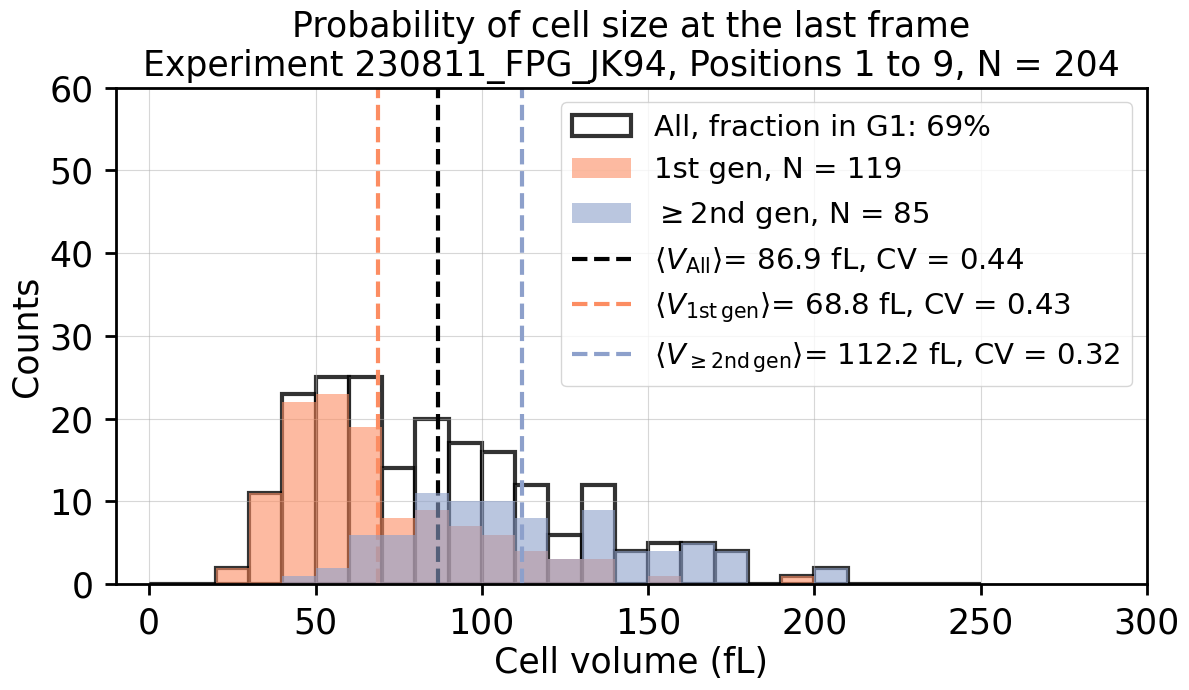

In [41]:
#Remove outliers if any?
trunk = 0
if trunk:
    outliers = np.where(np.array(end_vol)> 200)
    end_cc = np.delete(np.array(end_cc),outliers)
    end_gen = np.delete(np.array(end_gen),outliers)
    end_vol = np.delete(np.array(end_vol),outliers)

daughter_end_vol = np.array(end_vol)[np.where(np.array(end_gen) == 1)]
mother_end_vol = np.array(end_vol)[np.where(np.array(end_gen) != 1)]

ncell = len(end_vol)
ndaughter = len(daughter_end_vol)
nmother = len(mother_end_vol)

prop_g1 = len(np.array(end_cc)[np.where(np.array(end_cc) == 'G1')])/ncell

bs=10
bins = np.arange(0,251,bs)


mean_end_vol = np.mean(end_vol)
std_end_vol = np.std(end_vol)
cv_end_vol = std_end_vol/mean_end_vol

mean_daughter_end_vol = np.mean(daughter_end_vol)
std_daughter_end_vol = np.std(daughter_end_vol)
cv_daughter_end_vol = std_daughter_end_vol/mean_daughter_end_vol

mean_mother_end_vol = np.mean(mother_end_vol)
std_mother_end_vol = np.std(mother_end_vol)
cv_mother_end_vol = std_mother_end_vol/mean_mother_end_vol

f, ax = plt.subplots(1,1,figsize=(12,7),tight_layout=0)
ax = set_axes(ax)

plt.hist(end_vol,histtype='barstacked',bins=bins,density=0,facecolor='w',edgecolor='k',lw=3,alpha=0.8,zorder=1
         ,label='All, fraction in G1: %2.f'%(prop_g1*100)+'%')
plt.hist(daughter_end_vol,histtype='barstacked',bins=bins,density=0,facecolor=colors[1],edgecolor=colors[1]
         ,lw=0,alpha=0.6,zorder=2,label='1st gen, N = %i'%ndaughter)
plt.hist(mother_end_vol,histtype='barstacked',bins=bins,density=0,facecolor=colors[2],edgecolor=colors[2]
         ,lw=0,alpha=0.6,zorder=3,label=r'$\geq$2nd gen, N = %i'%nmother)

ax.axvline(mean_end_vol,ls='--',lw=3,color='k',label=r'$\langle V_{\rm All} \rangle$= %.1f fL, CV = %.2f'%(mean_end_vol,cv_end_vol))
ax.axvline(mean_daughter_end_vol,ls='--',lw=3,color=colors[1],label=r'$\langle V_{\rm 1st\,gen} \rangle$= %.1f fL, CV = %.2f'%(mean_daughter_end_vol,cv_daughter_end_vol))
ax.axvline(mean_mother_end_vol,ls='--',lw=3,color=colors[2],label=r'$\langle V_{\rm \geq 2nd\,gen} \rangle$= %.1f fL, CV = %.2f'%(mean_mother_end_vol,cv_mother_end_vol))

ax.set_xlim([-10,300])
ax.set_ylim([0,60])
ax.set_ylabel('Counts',fontsize = ax_fontdict['size'])
#ax.set_yticks([0,0.01,0.02,0.03,0.04])
ax.set_xlabel('Cell volume (fL)',fontsize = ax_fontdict['size'])
plt.grid(alpha=0.5,zorder=1)

ax.set_title('Probability of cell size at the last frame\nExperiment %s, Positions 1 to %i, N = %i'%(experiment,max_pos,ncell)
             ,fontsize = ax_fontdict['size'],pad=ax_fontdict['pad'])

plt.legend(fontsize = ax_fontdict['size']-4,ncol=1)

#plt.savefig(os.path.join("Experiments",experiment,'size_last_frame.png'),dpi=450)
plt.show()

___
___
___
___
## Combine all positions for ALL experiments of a single mutant

Select the MUTANT you would like to load.

In [86]:
mutant = "cln3whi5" #"cln3whi5", "cln3"

if mutant == 'cln3whi5':
    experiments = ["230822_JX_JK93","230823_FPG_JK93"]
elif mutant == 'cln3':
    experiments = ["230811_FPG_JK94","230830_FPG_JK94"]
else:
    experiments = []
window = 3
framerate = 6 # For my movies, 6 min. For Yagya's and Devon's, 3 min. 
logreg_flag = 0

first_gen_vol_birth = []
first_gen_g1_growth = []
first_gen_g1_growth_smooth_vol = []
first_gen_vol_g1_s = []
fg_vg1s_relgen = {}

daughter_g1_length = []
mother_g1_length = []
mother_vol_birth = []
mother_vol_g1_s = []

end_vol = []
end_gen = []
end_cc = []

return_map_n = []
return_map_np1 = []
return_map_gen_n = []
    
analysis_dict = {}
for iexp, experiment in enumerate(experiments):
    
    if experiment == "230811_FPG_JK94":
        max_pos = 9
    elif experiment == "230822_JX_JK93":
        max_pos = 8
    elif experiment == "230823_FPG_JK93":
        max_pos = 11
    elif experiment == "230830_FPG_JK94":
        max_pos = 7
    else:
        max_pos = 1

    first_gen_vol_birth.append([])
    first_gen_g1_growth_smooth_vol.append([])
    first_gen_g1_growth.append([])
    first_gen_vol_g1_s.append([])
    ####
    fg_vg1s_relgen[experiment] = {}
    ####
    daughter_g1_length.append([])
    
    mother_g1_length.append([])
    mother_vol_birth.append([])
    mother_vol_g1_s.append([])

    end_vol.append([])
    end_gen.append([])
    end_cc.append([])
    
    return_map_n.append([])
    return_map_np1.append([])
    return_map_gen_n.append([])
    
    analysis_dict[experiment] = {}
    print('Experiment: '+experiment+'\n')
    
    for pos in range(1,max_pos+1):
        print('Position: '+str(pos))

        if experiment == "230823_FPG_JK93":
            if pos < 10:
                load_path = glob.glob(os.path.join("Movies",experiment,"Position_"+str(pos),experiment+"_pos*_g_s0"+str(pos)+"_acdc_output.csv"))[0]
            else:
                load_path = glob.glob(os.path.join("Movies",experiment,"Position_"+str(pos),experiment+"_pos*_g_s"+str(pos)+"_acdc_output.csv"))[0]
        else:
            load_path = glob.glob(os.path.join("Movies",experiment,"Position_"+str(pos),experiment+"_pos*_g_s"+str(pos)+"_acdc_output.csv"))[0]

        master_df = pd.read_csv(load_path)
        relevant_columns = ["frame_i","time_minutes","Cell_ID","cell_area_um2","cell_cycle_stage","cell_vol_fl",
                           "division_frame_i","emerg_frame_i","generation_num","is_cell_dead","is_cell_excluded",
                           "is_history_known","relationship","relative_ID"]
        filtered_df = master_df.loc[:, relevant_columns]

        IDS = np.unique(np.array(filtered_df["Cell_ID"]))
        analysis_dict[experiment]['Position_'+str(pos)] = {} #This is the nested analysis dictionary

        for i,ID in enumerate(IDS):
            # Loop over each unique cell ID
            analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(ID)] = {} # Add an item in the dict. for each ID
            gen_num = np.unique(filtered_df[filtered_df.Cell_ID == ID]["generation_num"]) # Get each generation for each ID

            for gen in gen_num:
                # Loop over each unique generation number. If == 0, it's a bud. 

                temp_df = filtered_df[(filtered_df.Cell_ID == ID) & (filtered_df.generation_num == gen)]
                if 1 in np.array(temp_df["is_cell_excluded"]) or 1 in np.array(temp_df["is_cell_dead"]) or 0 in np.array(temp_df["is_history_known"]):
                    continue
                #if np.array(temp_df["is_cell_excluded"])[0] == 1 or np.array(temp_df["is_cell_dead"])[0] == 1 or np.array(temp_df["is_history_known"])[0] == 0:
                    #continue
                # For each ID and Generation, we get the time, volume and cell cycle stage series.
                vol = np.array(temp_df["cell_vol_fl"])
                time = np.array(temp_df["time_minutes"])
                cc = np.array(temp_df["cell_cycle_stage"])
                
                g1 = np.where(cc == 'G1')[0]
                # Is the cell in G1? Record the initial size V(t_i) and the subsequent growth in 
                # the time frame \Delta V = V(t_i+1) - V(t_i) to estimate the G1 growth rate
                if len(g1) > 2*np.floor(window/2) and gen == 1:
                    smooth_vol_g1 = np.convolve(vol[g1], np.ones(window)/window, mode='valid')
                    first_gen_g1_growth_smooth_vol[iexp].extend(smooth_vol_g1[:-1])
                    first_gen_g1_growth[iexp].extend(np.diff(smooth_vol_g1))

                rel_ID_at_birth = np.array(temp_df["relative_ID"])[0]
                rel_ID =  np.array(temp_df["relative_ID"])
                # Add these to the dict. 
                analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)] = {'Time':time,'Volume':vol,'Cell_cycle':cc,'Rel_ID_at_birth':rel_ID_at_birth,'Rel_ID':rel_ID}

                # Now we will extract specific values corresponding to birth, G1/S and division for each cell and each gen.
                vol_birth = vol[0]
                time_birth = time[0]
                analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_birth'] = vol_birth
                analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Time_birth'] = time_birth

                flag = 0
                flag2 = 0
                for j, jcc in enumerate(cc):
                    if np.array(temp_df["is_cell_excluded"])[j] == 1 or np.array(temp_df["is_cell_dead"])[j] == 1 or np.array(temp_df["is_history_known"])[j] == 0:
                        continue

                    g1_s = np.where(cc == 'S')[0]
                    
                    # Has the cell undergone G1/S transition 
                    if len(g1_s) != 0 and gen != 0:
                        true_g1_s = g1_s[0]
                        vol_g1_s = vol[true_g1_s]
                        time_g1_s = time[true_g1_s] #Time since beginning of the generation
                        g1_length = time_g1_s - time_birth

                        analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_G1_S'] = vol_g1_s
                        analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Time_G1_S'] = time_g1_s
                        analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['G1_length'] = g1_length
                    
                        if gen == 1 and flag == 0:
                            first_gen_vol_g1_s[iexp].append(vol_g1_s)
                            daughter_g1_length[iexp].append(g1_length)
                            first_gen_vol_birth[iexp].append(vol_birth)
                            flag = 1
                        elif gen > 1 and flag2 == 0:
                            mother_g1_length[iexp].append(g1_length)
                            mother_vol_birth[iexp].append(vol_birth)
                            mother_vol_g1_s[iexp].append(vol_g1_s)
                            flag2 = 1

                    # Has the cell divided before the last frame? 
                    if gen != gen_num[-1] and gen != 0:
                        time_div = time[-1]
                        vol_div = vol[-1]
                        sg2m_length = time_div - time_g1_s

                        analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_division'] = vol_div
                        analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Time_division'] = time_div
                        analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['SG2M_length'] = sg2m_length

                    # Last frame steady-state volumes
                    if gen == gen_num[-1] and j == len(cc)-1:

                        vol_last_frame = vol[-1]
                        analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_last'] = vol_last_frame  
                        analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Cell_cycle_last'] = jcc

                        #Add bud volume to mother cell body
                        if gen == 0:
                            relative_ID = np.array(filtered_df[(filtered_df.Cell_ID == ID) & (filtered_df.generation_num == gen)]["relative_ID"])[0]
                            relative_gen_num = np.unique(filtered_df[filtered_df.Cell_ID == relative_ID]["generation_num"])
                            if 'Generation_'+str(relative_gen_num[-1]) in analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(relative_ID)].keys():
                                analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(relative_ID)]['Generation_'+str(relative_gen_num[-1])]['Volume_last'] += vol_last_frame
                            else:
                                continue
        # Once we have all the info in analysis dict, re-loop over all IDs and gens to record the last volumes of each cell line
        for i,ID in enumerate(analysis_dict[experiment]['Position_'+str(pos)].keys()):
            for j,gen in enumerate(analysis_dict[experiment]['Position_'+str(pos)][ID].keys()):
                if 'Volume_last' in analysis_dict[experiment]['Position_'+str(pos)][ID][gen] and gen[-1] != "0":
                    #if analysis_dict[ID][gen]['Volume_last'] < 20:
                        #print(ID,gen,analysis_dict[ID][gen]['Volume_last'])
                    end_vol[iexp].append(analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Volume_last'])
                    end_gen[iexp].append(int(gen[-1]))
                    end_cc[iexp].append(analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Cell_cycle_last'])
        
        for i,ID in enumerate(analysis_dict[experiment]['Position_'+str(pos)].keys()):
            for j,gen in enumerate(analysis_dict[experiment]['Position_'+str(pos)][ID].keys()):
                # Not a bud, not the last generation and has gone through G1/S
                if j != 0 and 'Generation_'+str(j+1) in analysis_dict[experiment]['Position_'+str(pos)][ID].keys() and 'Volume_G1_S' in analysis_dict[experiment]['Position_'+str(pos)][ID]['Generation_'+str(j+1)].keys():
                    #V_n
                    #print(ID,gen)
                    #print(ID,gen,analysis_dict['Position_'+str(pos)][ID][gen].keys())
                    return_map_n[iexp].append(analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Volume_G1_S'])
                    #V_n+1
                    return_map_np1[iexp].append(analysis_dict[experiment]['Position_'+str(pos)][ID]['Generation_'+str(j+1)]['Volume_G1_S'])
                    # Gen(n)
                    return_map_gen_n[iexp].append(j)
                    
        for i,ID in enumerate(analysis_dict[experiment]['Position_'+str(pos)].keys()):
            for j,gen in enumerate(analysis_dict[experiment]['Position_'+str(pos)][ID].keys()):
                if j == 1:
                    vol_birth = analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Volume_birth']
                    
                    # This is the parent cell ID.
                    rel_ID = analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Rel_ID_at_birth']
                    
                    #print(analysis_dict[experiment]['Position_'+str(pos)][rel_ID][gen]['Rel_ID_at_birth'])
        
        # Here we look at the lineage of 1st gen daughter cells that go through START. 
        for i,ID in enumerate(analysis_dict[experiment]['Position_'+str(pos)].keys()):
            for j,gen in enumerate(analysis_dict[experiment]['Position_'+str(pos)][ID].keys()):
                # We want information about 1st gen daughter cells that have gone through START.
                # Select ID and Gen that correspond to this. 
                if gen == "Generation_1" and 'Time_G1_S' in analysis_dict[experiment]['Position_'+str(pos)][ID][gen].keys():
                    # Record the time of birth of the Gen 1 daughter cell.
                    # This should also correspond to time of birth of the parent cell.
                    temp_time_birth = analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Time_birth']
                    
                    # Record the relative ID of the Gen 1 daughter cell. 
                    # This is the parent cell ID. 
                    rel_ID = analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Rel_ID_at_birth']
                    
                    # Loop through the generations of the relative ID
                    for rel_gen in analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(rel_ID)].keys():
                        # Identify the corresponding generation
                        # Not every 1st gen cells will have a corresponding relative whose history is known, so 
                        # sample size of first_gen_vol_g1_s_rel is smaller than first_gen_vol_g1_s
                        temp_rel_df = filtered_df[(filtered_df.Cell_ID == int(rel_ID)) & (filtered_df.generation_num == int(rel_gen[-1])-1)]
                        if np.any(np.array(temp_rel_df["is_cell_excluded"]) == 1) or np.any(np.array(temp_rel_df["is_cell_dead"]) == 1) or np.any(np.array(temp_rel_df["is_history_known"]) == 0):
                            continue
                        elif temp_time_birth == analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(rel_ID)][rel_gen]["Time_birth"]:
                            #first_gen_vol_g1_s_rel_gen.append(int(rel_gen[-1])-1)
                            # Record previous generation
                            if 'Generation_'+str(int(rel_gen[-1])-1) not in fg_vg1s_relgen[experiment].keys():
                                # If we haven't already recorded the G1/S volume of the 1st gen daughter cell born
                                # from a rel_gen[-1]-1 aged cell (relative gen. of the parent at birth -1 = relative gen
                                # of the parent when it created this bud).
                                # Create a dict that will store this info. This will have 2 keys, one for Volume at G1/S
                                # and one for the Mother volume at G1/S from the previous generation
                                fg_vg1s_relgen[experiment]['Generation_'+str(int(rel_gen[-1])-1)] = {}
                                fg_vg1s_relgen[experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Volume_G1_S'] = []
                                fg_vg1s_relgen[experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Volume_birth'] = []
                                
                                fg_vg1s_relgen[experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Mother_volume_G1_S'] = []
                                fg_vg1s_relgen[experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Mother_volume_birth'] = []
                                fg_vg1s_relgen[experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Mother_volume_division'] = []
                            #print(fg_vg1s_relgen[experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Mother_volume_G1_S'])
                            #print(analysis_dict[experiment]['Position_'+str(pos)][ID][gen].keys())
                            fg_vg1s_relgen[experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Volume_G1_S'].append(analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Volume_G1_S'])
                            fg_vg1s_relgen[experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Volume_birth'].append(analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Volume_birth'])
                            fg_vg1s_relgen[experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Mother_volume_G1_S'].append(analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(rel_ID)]['Generation_'+str(int(rel_gen[-1])-1)]['Volume_G1_S'])
                            fg_vg1s_relgen[experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Mother_volume_birth'].append(analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(rel_ID)]['Generation_'+str(int(rel_gen[-1])-1)]['Volume_birth'])
                            fg_vg1s_relgen[experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Mother_volume_division'].append(analysis_dict[experiment]['Position_'+str(pos)]['Cell_'+str(rel_ID)]['Generation_'+str(int(rel_gen[-1])-1)]['Volume_division'])
agg = 1
md_asymmetry = [[],[]]
if agg == 1:
    subhist=[[],[]]
    birth_subhist = [[],[]]
    mother_subhist = [[],[]]
    mother_birth_subhist = [[],[]]
    mother_div_subhist = [[],[]]
    for iexp, experiment in enumerate(experiments):
        for i,rel_gen in enumerate(fg_vg1s_relgen[experiment].keys()):
            md_asymmetry[1].extend(fg_vg1s_relgen[experiment][rel_gen]['Volume_birth'])
            md_asymmetry[0].extend(fg_vg1s_relgen[experiment][rel_gen]['Mother_volume_division'])
            if i == 0:
                subhist[0].extend(fg_vg1s_relgen[experiment][rel_gen]['Volume_G1_S'])
                birth_subhist[0].extend(fg_vg1s_relgen[experiment][rel_gen]['Volume_birth'])
                mother_subhist[0].extend(fg_vg1s_relgen[experiment][rel_gen]['Mother_volume_G1_S'])
                mother_birth_subhist[0].extend(fg_vg1s_relgen[experiment][rel_gen]['Mother_volume_birth'])
                mother_div_subhist[0].extend(fg_vg1s_relgen[experiment][rel_gen]['Mother_volume_division'])
            else:
                subhist[1].extend(fg_vg1s_relgen[experiment][rel_gen]['Volume_G1_S'])
                birth_subhist[1].extend(fg_vg1s_relgen[experiment][rel_gen]['Volume_birth'])
                mother_subhist[1].extend(fg_vg1s_relgen[experiment][rel_gen]['Mother_volume_G1_S'])
                mother_birth_subhist[1].extend(fg_vg1s_relgen[experiment][rel_gen]['Mother_volume_birth'])
                mother_div_subhist[1].extend(fg_vg1s_relgen[experiment][rel_gen]['Mother_volume_division'])
else:
    subhist = []
    birth_subhist = []
    mother_subhist = []
    mother_birth_subhist = []
    mother_div_subhist = []
    for iexp, experiment in enumerate(experiments):
        for i,rel_gen in enumerate(fg_vg1s_relgen[experiment].keys()):
            md_asymmetry[1].extend(fg_vg1s_relgen[experiment][rel_gen]['Volume_birth'])
            md_asymmetry[0].extend(fg_vg1s_relgen[experiment][rel_gen]['Mother_volume_division'])
            subhist.append([])
            birth_subhist.append([])
            mother_subhist.append([])
            mother_birth_subhist.append([])
            mother_div_subhist.append([])
            subhist[i].extend(fg_vg1s_relgen[experiment][rel_gen]['Volume_G1_S'])
            birth_subhist[i].extend(fg_vg1s_relgen[experiment][rel_gen]['Volume_birth'])
            mother_subhist[i].extend(fg_vg1s_relgen[experiment][rel_gen]['Mother_volume_G1_S'])
            mother_birth_subhist[i].extend(fg_vg1s_relgen[experiment][rel_gen]['Mother_volume_birth'])
            mother_div_subhist[i].extend(fg_vg1s_relgen[experiment][rel_gen]['Mother_volume_division'])

Experiment: 230822_JX_JK93

Position: 1
Position: 2
Position: 3
Position: 4
Position: 5
Position: 6
Position: 7
Position: 8
Experiment: 230823_FPG_JK93

Position: 1
Position: 2
Position: 3
Position: 4
Position: 5
Position: 6
Position: 7
Position: 8
Position: 9
Position: 10
Position: 11


___
## 1st. gen G1 growth rate estimate
This uses **smoothed cell volumes** in G1 using a rolling average with a window correspondg to the `window` notebook variable in the processing step. If cells grow exponentially, the interframe growth rate should be linearily increasing with cell volumes. 
___

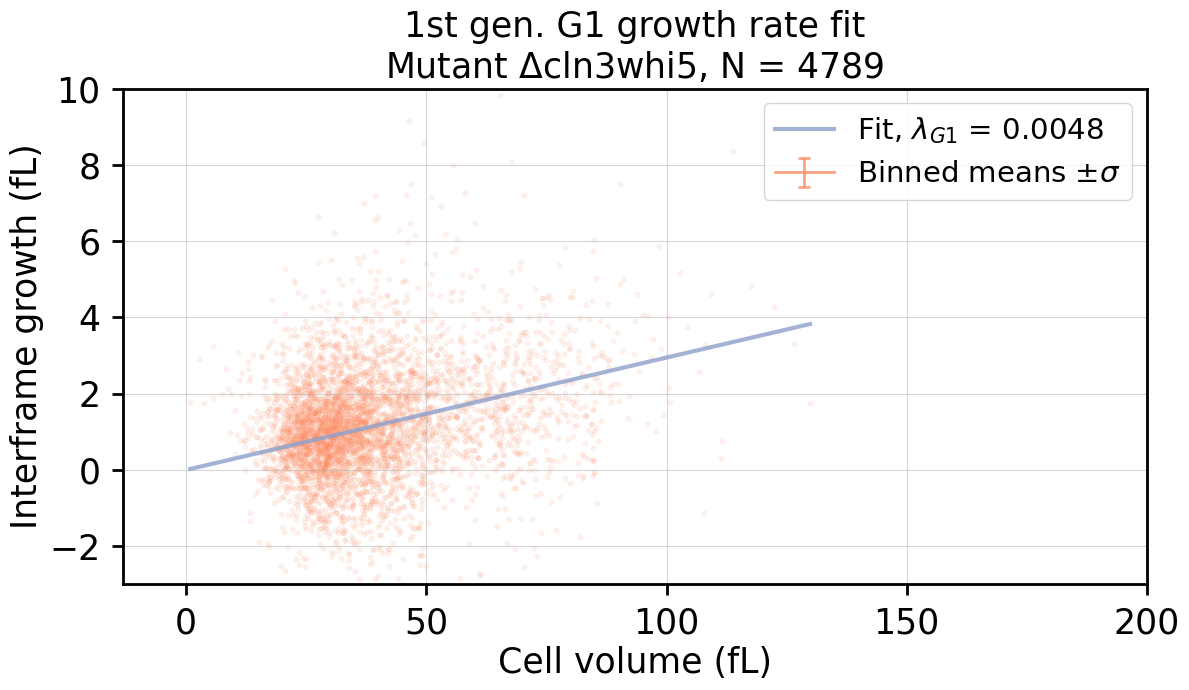

In [87]:
X, Y = np.array(np.concatenate(first_gen_g1_growth_smooth_vol)).reshape(-1,1), np.array(np.concatenate(first_gen_g1_growth)).reshape(-1,1)

regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(X,Y)

# Make predictions using the testing set
x_plot = np.linspace(np.amin(X),np.amax(X),50).reshape(-1,1)
y_plot = regr.predict(x_plot)
slope = regr.coef_[0][0]
#intercept = regr.intercept_[0]
score = regr.score(X, Y)
G1_growth_rate = np.log(slope+1)/framerate
# Binned Statistics 
n_bins = 10
bin_std, bin_edges, binnumber = stats.binned_statistic(np.concatenate(first_gen_g1_growth),np.concatenate(first_gen_g1_growth_smooth_vol),statistic='std', bins=n_bins)
bin_means, bin_edges, binnumber = stats.binned_statistic(np.concatenate(first_gen_g1_growth),np.concatenate(first_gen_g1_growth_smooth_vol),statistic='mean', bins=n_bins)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

f,ax = plt.subplots(1,1,figsize=(12,7),tight_layout=1)
ax = set_axes(ax)
ax.scatter(X,Y,s=10,color=colors[1],alpha=0.1,zorder=1)
ax.errorbar(bin_centers,bin_means,yerr=bin_std,capsize=4,capthick=2,c=colors[1],lw=2,zorder=2,alpha=0.8,label=r'Binned means $\pm \sigma$')  
ax.plot(x_plot,y_plot,c=colors[2],lw=3,alpha=0.8,zorder=3,label='Fit, $\lambda_{G1}$ = %.4f'%G1_growth_rate)
#ax.set_xlim([0,140])
ax.set_ylim(-3,10)

ax.set_ylabel('Interframe growth (fL)',fontsize = ax_fontdict['size'])
ax.set_yticks([-2,0,2,4,6,8,10])
ax.set_xlabel('Cell volume (fL)',fontsize = ax_fontdict['size'])
ax.set_xticks(np.arange(0,201,50))
plt.grid(alpha=0.5,zorder=1)

ax.set_title('1st gen. G1 growth rate fit\n'+r'Mutant $\Delta$%s, $\rm N$ = %i'%(mutant,len(X))
             ,fontsize = ax_fontdict['size'],pad=ax_fontdict['pad'])
plt.legend(fontsize = ax_fontdict['size']-4,ncol=1)

#plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'_first_gen_g1_growth_rate_smoothwindow_%i.png'%window),dpi=450)
plt.show()

___
## Plot 1st. gen cells volume at G1/S transition
___ 

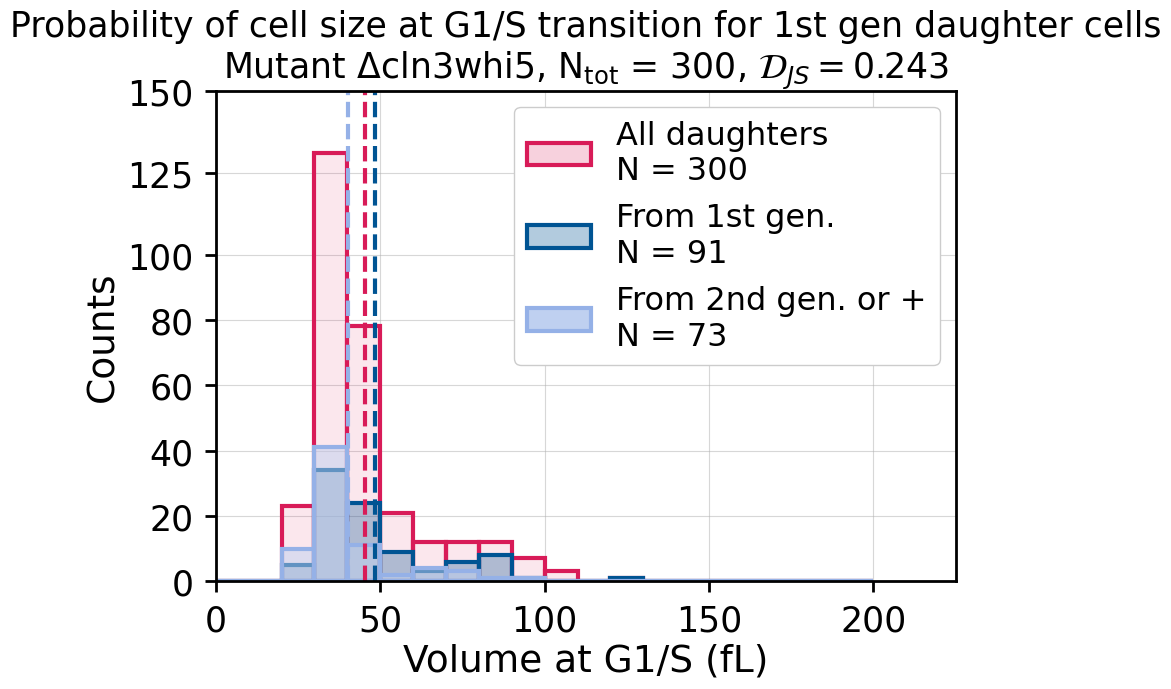

In [88]:
ncell = len(np.concatenate(first_gen_vol_g1_s))

bs = 10
bs_rel = 10
bins = np.arange(0,201,bs)
bins_rel = np.arange(0,201,bs_rel)
x_plot = np.arange(0,201,1)

bw=10
kde = KernelDensity(kernel='gaussian',bandwidth=bw).fit(np.array(np.concatenate(first_gen_vol_g1_s)).reshape(-1,1))
log_dens = kde.score_samples(x_plot.reshape(-1,1))

mean_vol_g1_s = np.mean(np.concatenate(first_gen_vol_g1_s))
std_vol_g1_s = np.std(np.concatenate(first_gen_vol_g1_s))
cv_vol_g1_s = std_vol_g1_s/mean_vol_g1_s

c_patch_START_R,c_patch_START_G,c_patch_START_B = mpl.colors.to_rgb(new_color_all)
c_patch_d1_R,c_patch_d1_G,c_patch_d1_B = mpl.colors.to_rgb(new_color_d1)
c_patch_d2_R,c_patch_d2_G,c_patch_d2_B = mpl.colors.to_rgb(new_color_d2)

f, ax = plt.subplots(1,1,figsize=(9,7),tight_layout=1)
ax = set_axes(ax)

plt.hist(np.concatenate(first_gen_vol_g1_s),bins=bins,density=0,facecolor=[c_patch_START_R,c_patch_START_G,c_patch_START_B,0.1]
         ,edgecolor=[c_patch_START_R,c_patch_START_G,c_patch_START_B,1],lw=3,zorder=3,label='All daughters at G1/S\nN = %i'%ncell)
#plt.hist(np.concatenate(first_gen_vol_g1_s),bins=bins,density=0,facecolor='w',edgecolor=new_color_all,lw=3,alpha=1,zorder=2)
ax.axvline(mean_vol_g1_s,ls='--',lw=3,zorder=6,color=new_color_all)

if agg == 1:
    p_fromdaughters,edges = np.histogram(subhist[0],bins=bins,density=1)
    p_frommothers,edges = np.histogram(subhist[1],bins=bins,density=1)
    jsd = distance.jensenshannon(p_fromdaughters,p_frommothers)
    for i in range(len(subhist)):
        if i == 0:
            plt.hist(subhist[i],bins=bins,density=0,facecolor=[c_patch_d1_R,c_patch_d1_G,c_patch_d1_B,0.3],edgecolor=[c_patch_d1_R,c_patch_d1_G,c_patch_d1_B,1],lw=3,zorder=3,label='From 1st gen.\nN = %i'%len(subhist[i]))
            #plt.hist(subhist[i],bins=bins,density=0,facecolor='w',edgecolor=new_color_d1,lw=3,alpha=1,zorder=2)
            sub_mean_vol_g1_s = np.mean(subhist[i])
            sub_std_vol_g1_s = np.std(subhist[i])
            sub_cv_vol_g1_s = sub_std_vol_g1_s/sub_mean_vol_g1_s
            ax.axvline(sub_mean_vol_g1_s,ls='--',lw=3,color=new_color_d1,zorder=6)
        else:
            plt.hist(subhist[i],bins=bins,density=0,facecolor=[c_patch_d2_R,c_patch_d2_G,c_patch_d2_B,0.3],edgecolor=[c_patch_d2_R,c_patch_d2_G,c_patch_d2_B,1],lw=3,zorder=5,label='From 2nd gen. or later\nN = %i'%len(subhist[i]))
            plt.hist(subhist[i],bins=bins,density=0,facecolor='w',edgecolor=new_color_d2,lw=0,alpha=0.3,zorder=4)
            sub_mean_vol_g1_s = np.mean(subhist[i])
            sub_std_vol_g1_s = np.std(subhist[i])
            sub_cv_vol_g1_s = sub_std_vol_g1_s/sub_mean_vol_g1_s
            ax.axvline(sub_mean_vol_g1_s,ls='--',lw=3,color=new_color_d2,zorder=6)
else:
    for i in range(len(subhist)):
        plt.hist(subhist[i],bins=bins,density=0,facecolor=colors[i+1],edgecolor=colors[i+1],lw=0,alpha=0.3,label='Born from %i gen cells, N = %i'%(int(i+1),len(subhist[i])))
        sub_mean_vol_g1_s = np.mean(subhist[i])
        sub_std_vol_g1_s = np.std(subhist[i])
        sub_cv_vol_g1_s = sub_std_vol_g1_s/sub_mean_vol_g1_s
        ax.axvline(sub_mean_vol_g1_s,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_g1_s,sub_cv_vol_g1_s))


l_patch = []
l_patch.append(mpl.patches.Patch(facecolor=[c_patch_START_R,c_patch_START_G,c_patch_START_B,0.2],edgecolor=[c_patch_START_R,c_patch_START_G,c_patch_START_B,1],lw=3,)) 
l_patch.append(mpl.patches.Patch(facecolor=[c_patch_d1_R,c_patch_d1_G,c_patch_d1_B,0.3],edgecolor=[c_patch_d1_R,c_patch_d1_G,c_patch_d1_B,1],lw=3,)) 
l_patch.append(mpl.patches.Patch(facecolor=[c_patch_d2_R,c_patch_d2_G,c_patch_d2_B,0.6],edgecolor=[c_patch_d2_R,c_patch_d2_G,c_patch_d2_B,1],lw=3,)) 
l_label = []
l_label.append('All daughters\nN = %i'%ncell)
l_label.append('From 1st gen.\nN = %i'%len(subhist[0]))
l_label.append('From 2nd gen. or +\nN = %i'%(len(subhist[1])))

ax.set_xlim([0,225])

ax.set_ylabel('Counts',fontsize = ax_fontdict['size']+2)
ax.set_yticks([0,20,40,60,80,100,125,150,175,200])
ax.set_ylim([0,150.1])
ax.set_xlabel('Volume at G1/S (fL)',fontsize = ax_fontdict['size']+2)
plt.grid(alpha=0.5,zorder=1)

ax.set_title('Probability of cell size at G1/S transition for 1st gen daughter cells\n'+r'Mutant $\Delta$%s, $\rm N_{tot}$ = %i, $\mathcal{D}_{JS} = %.3f$'%(mutant,ncell,jsd)
             ,fontsize = ax_fontdict['size'],pad=ax_fontdict['pad'])

ax.legend(l_patch,l_label,fontsize = ax_fontdict['size']-2,ncol=1,framealpha=1).set_zorder(100)
plt.grid(alpha=0.5,zorder=0)

#plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'_size_first_gen_daughter_g1_s_subpopulations.png'),dpi=450)
plt.show()

___
## Subfigure: Plot volume at birth, G1/S and division for the parents of the daughter subpopulations identified in the previous plot (i.e. D1 and D2+)
___ 

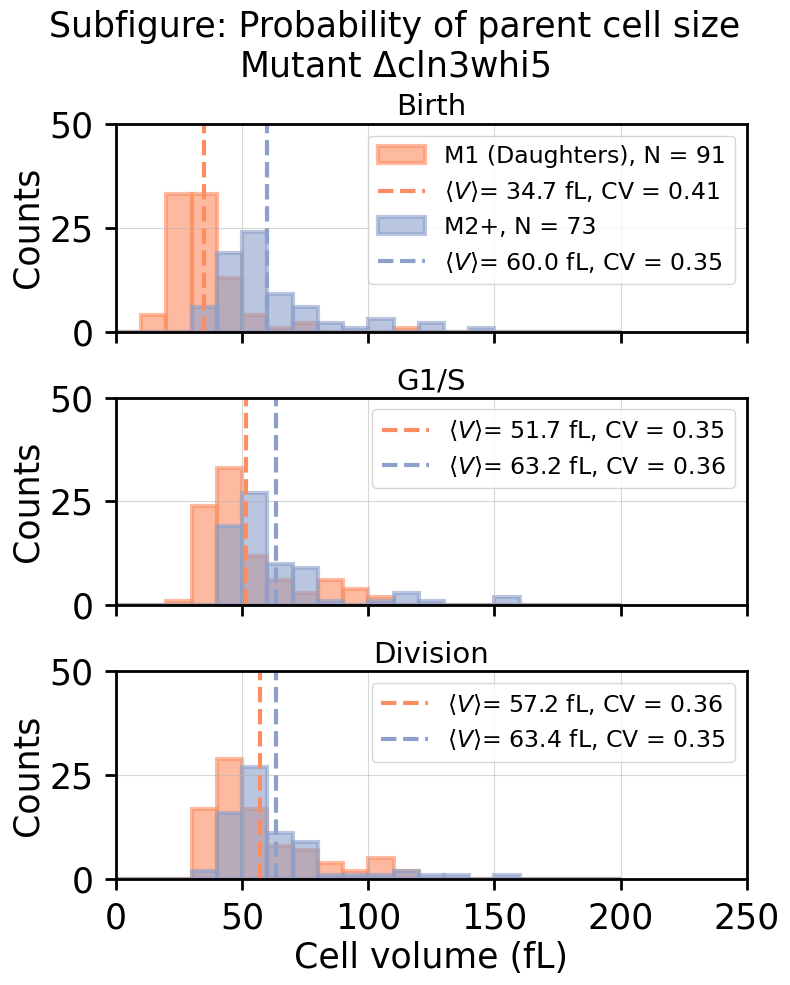

In [89]:


f, ax = plt.subplots(3,1,figsize=(8,10),tight_layout=0)
ax0 = set_axes(ax[0])
ax1 = set_axes(ax[1])
ax2 = set_axes(ax[2])

#plt.hist(mother_vol_g1_s,bins=bins,density=0,facecolor='w',edgecolor='k',lw=3,alpha=1,label='All > 2nd gen cells at G1/S')
#ax.axvline(mean_vol_g1_s,ls='--',lw=3,color='k',label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(mean_vol_g1_s,cv_vol_g1_s))

if agg == 1:
    for i in range(len(mother_subhist)):
        sub_mean_vol_birth = np.mean(mother_birth_subhist[i])
        sub_std_vol_birth = np.std(mother_birth_subhist[i])
        sub_cv_vol_birth = sub_std_vol_birth/sub_mean_vol_birth
            
        sub_mean_vol_g1_s = np.mean(mother_subhist[i])
        sub_std_vol_g1_s = np.std(mother_subhist[i])
        sub_cv_vol_g1_s = sub_std_vol_g1_s/sub_mean_vol_g1_s
            
        sub_mean_vol_div = np.mean(mother_div_subhist[i])
        sub_std_vol_div = np.std(mother_div_subhist[i])
        sub_cv_vol_div = sub_std_vol_div/sub_mean_vol_div
        if i == 0:
            ax0.hist(mother_birth_subhist[i],bins=bins,density=0,facecolor=colors[1],edgecolor=colors[1],lw=3,alpha=0.6,label='M1 (Daughters), N = %i'%len(mother_birth_subhist[i]))
            ax1.hist(mother_subhist[i],bins=bins,density=0,facecolor=colors[1],edgecolor=colors[1],lw=3,alpha=0.6)
            ax2.hist(mother_div_subhist[i],bins=bins,density=0,facecolor=colors[1],edgecolor=colors[1],lw=3,alpha=0.6)
            
            ax0.axvline(sub_mean_vol_birth,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_birth,sub_cv_vol_birth))
            ax1.axvline(sub_mean_vol_g1_s,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_g1_s,sub_cv_vol_g1_s))
            ax2.axvline(sub_mean_vol_div,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_div,sub_cv_vol_div))
            
        else:
            ax0.hist(mother_birth_subhist[i],bins=bins,density=0,facecolor=colors[2],edgecolor=colors[2],lw=3,alpha=0.6,label='M2+, N = %i'%len(mother_birth_subhist[i]))
            ax1.hist(mother_subhist[i],bins=bins,density=0,facecolor=colors[2],edgecolor=colors[2],lw=3,alpha=0.6)
            ax2.hist(mother_div_subhist[i],bins=bins,density=0,facecolor=colors[2],edgecolor=colors[2],lw=3,alpha=0.6)
            
            ax0.axvline(sub_mean_vol_birth,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_birth,sub_cv_vol_birth))
            ax1.axvline(sub_mean_vol_g1_s,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_g1_s,sub_cv_vol_g1_s))
            ax2.axvline(sub_mean_vol_div,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_div,sub_cv_vol_div))
else:
    for i in range(len(mother_subhist)):
        sub_mean_vol_birth = np.mean(mother_birth_subhist[i])
        sub_std_vol_birth = np.std(mother_birth_subhist[i])
        sub_cv_vol_birth = sub_std_vol_birth/sub_mean_vol_birth
            
        sub_mean_vol_g1_s = np.mean(mother_subhist[i])
        sub_std_vol_g1_s = np.std(mother_subhist[i])
        sub_cv_vol_g1_s = sub_std_vol_g1_s/sub_mean_vol_g1_s
            
        sub_mean_vol_div = np.mean(mother_div_subhist[i])
        sub_std_vol_div = np.std(mother_div_subhist[i])
        sub_cv_vol_div = sub_std_vol_div/sub_mean_vol_div
        
        ax0.hist(mother_birth_subhist[i],bins=bins,density=0,facecolor=colors[2],edgecolor=colors[2],lw=3,alpha=0.6,label='i-th time mothers, N = %i'%len(mother_birth_subhist[i]))
        ax1.hist(mother_subhist[i],bins=bins,density=0,facecolor=colors[2],edgecolor=colors[2],lw=3,alpha=0.6,label='i-th time mothers, N = %i'%len(mother_subhist[i]))
        ax2.hist(mother_div_subhist[i],bins=bins,density=0,facecolor=colors[2],edgecolor=colors[2],lw=3,alpha=0.6,label='i-th time mothers, N = %i'%len(mother_div_subhist[i]))
            
        ax0.axvline(sub_mean_vol_birth,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_birth,sub_cv_vol_birth))
        ax1.axvline(sub_mean_vol_g1_s,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_g1_s,sub_cv_vol_g1_s))
        ax2.axvline(sub_mean_vol_div,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_div,sub_cv_vol_div))

ax0.set_title('Birth',fontsize=ax_fontdict['size']-4)
ax1.set_title('G1/S',fontsize=ax_fontdict['size']-4)
ax2.set_title('Division',fontsize=ax_fontdict['size']-4)

ax0.set_xticklabels('')
ax1.set_xticklabels('')

ax0.set_xlim([0,250])
ax1.set_xlim([0,250])
ax2.set_xlim([0,250])

ax0.set_ylim([0,50])
ax1.set_ylim([0,50])
ax2.set_ylim([0,50])

ax0.set_ylabel('Counts',fontsize = ax_fontdict['size'])
ax1.set_ylabel('Counts',fontsize = ax_fontdict['size'])
ax2.set_ylabel('Counts',fontsize = ax_fontdict['size'])
#ax.set_yticks([0,0.01,0.02,0.03,0.04])

ax2.set_xlabel('Cell volume (fL)',fontsize = ax_fontdict['size'])

ax0.grid(alpha=0.5,zorder=1)
ax1.grid(alpha=0.5,zorder=1)
ax2.grid(alpha=0.5,zorder=1)

plt.suptitle('Subfigure: Probability of parent cell size\n'+r'Mutant $\Delta$%s'%(mutant)
             ,fontsize = ax_fontdict['size'])

ax0.legend(fontsize = ax_fontdict['size']-8,ncol=1)
ax1.legend(fontsize = ax_fontdict['size']-8,ncol=1)
ax2.legend(fontsize = ax_fontdict['size']-8,ncol=1)

#plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'_parentsize_subpopulations.png'),dpi=450)
plt.show()

___
## Subfigure: size of daughter subpopulations (D1 and D2+) at birth and at G1/S
___

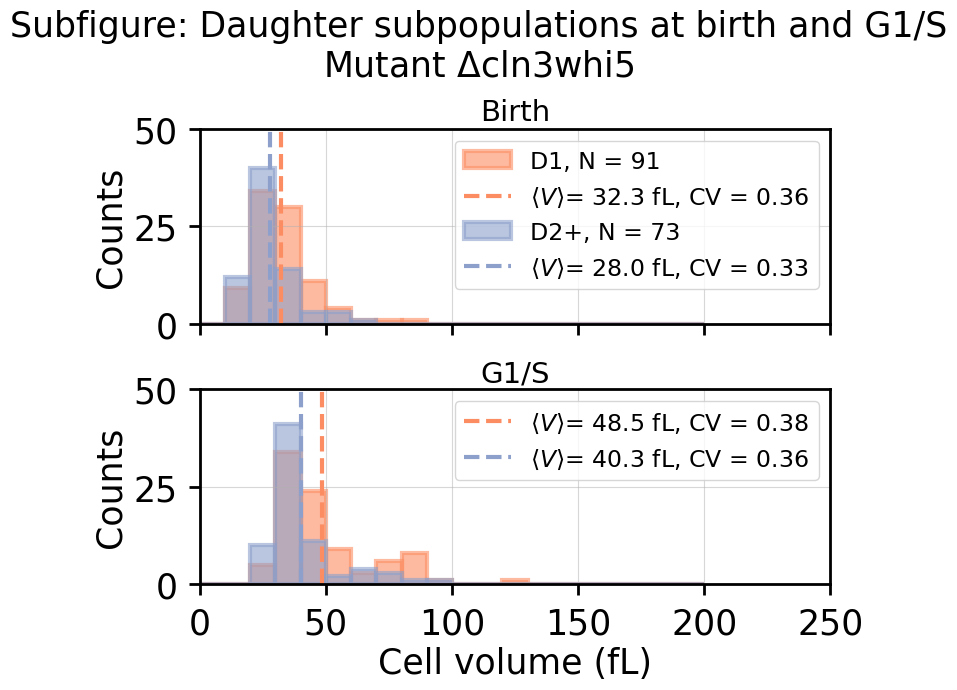

In [90]:
f, ax = plt.subplots(2,1,figsize=(8,7),tight_layout=0)
ax0 = set_axes(ax[0])
ax1 = set_axes(ax[1])

#plt.hist(mother_vol_g1_s,bins=bins,density=0,facecolor='w',edgecolor='k',lw=3,alpha=1,label='All > 2nd gen cells at G1/S')
#ax.axvline(mean_vol_g1_s,ls='--',lw=3,color='k',label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(mean_vol_g1_s,cv_vol_g1_s))

if agg == 1:
    for i in range(len(mother_subhist)):
        sub_mean_vol_birth = np.mean(birth_subhist[i])
        sub_std_vol_birth = np.std(birth_subhist[i])
        sub_cv_vol_birth = sub_std_vol_birth/sub_mean_vol_birth
            
        sub_mean_vol_g1_s = np.mean(subhist[i])
        sub_std_vol_g1_s = np.std(subhist[i])
        sub_cv_vol_g1_s = sub_std_vol_g1_s/sub_mean_vol_g1_s
        
        if i == 0:
            ax0.hist(birth_subhist[i],bins=bins,density=0,facecolor=colors[1],edgecolor=colors[1],lw=3,alpha=0.6,label='D1, N = %i'%len(birth_subhist[i]))
            ax1.hist(subhist[i],bins=bins,density=0,facecolor=colors[1],edgecolor=colors[1],lw=3,alpha=0.6)            
            ax0.axvline(sub_mean_vol_birth,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_birth,sub_cv_vol_birth))
            ax1.axvline(sub_mean_vol_g1_s,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_g1_s,sub_cv_vol_g1_s))            
        else:
            ax0.hist(birth_subhist[i],bins=bins,density=0,facecolor=colors[2],edgecolor=colors[2],lw=3,alpha=0.6,label='D2+, N = %i'%len(birth_subhist[i]))
            ax1.hist(subhist[i],bins=bins,density=0,facecolor=colors[2],edgecolor=colors[2],lw=3,alpha=0.6)            
            ax0.axvline(sub_mean_vol_birth,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_birth,sub_cv_vol_birth))
            ax1.axvline(sub_mean_vol_g1_s,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_g1_s,sub_cv_vol_g1_s))
else:
    for i in range(len(mother_subhist)):
        sub_mean_vol_birth = np.mean(birth_subhist[i])
        sub_std_vol_birth = np.std(birth_subhist[i])
        sub_cv_vol_birth = sub_std_vol_birth/sub_mean_vol_birth
            
        sub_mean_vol_g1_s = np.mean(subhist[i])
        sub_std_vol_g1_s = np.std(subhist[i])
        sub_cv_vol_g1_s = sub_std_vol_g1_s/sub_mean_vol_g1_s
                
        ax0.hist(birth_subhist[i],bins=bins,density=0,facecolor=colors[2],edgecolor=colors[2],lw=3,alpha=0.6,label='i-th time mothers, N = %i'%len(birth_subhist[i]))
        ax1.hist(subhist[i],bins=bins,density=0,facecolor=colors[2],edgecolor=colors[2],lw=3,alpha=0.6,label='i-th time mothers, N = %i'%len(subhist[i]))            
        ax0.axvline(sub_mean_vol_birth,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_birth,sub_cv_vol_birth))
        ax1.axvline(sub_mean_vol_g1_s,ls='--',lw=3,color=colors[i+1],label=r'$\langle V \rangle$= %.1f fL, CV = %.2f'%(sub_mean_vol_g1_s,sub_cv_vol_g1_s))

ax0.set_title('Birth',fontsize=ax_fontdict['size']-4)
ax1.set_title('G1/S',fontsize=ax_fontdict['size']-4)

ax0.set_xticklabels('')

ax0.set_xlim([0,250])
ax1.set_xlim([0,250])

ax0.set_ylim([0,50])
ax1.set_ylim([0,50])

ax0.set_ylabel('Counts',fontsize = ax_fontdict['size'])
ax1.set_ylabel('Counts',fontsize = ax_fontdict['size'])
#ax.set_yticks([0,0.01,0.02,0.03,0.04])

ax1.set_xlabel('Cell volume (fL)',fontsize = ax_fontdict['size'])

ax0.grid(alpha=0.5,zorder=1)
ax1.grid(alpha=0.5,zorder=1)

plt.suptitle('Subfigure: Daughter subpopulations at birth and G1/S\n'+r'Mutant $\Delta$%s'%(mutant)
             ,fontsize = ax_fontdict['size'])

ax0.legend(fontsize = ax_fontdict['size']-8,ncol=1)
ax1.legend(fontsize = ax_fontdict['size']-8,ncol=1)

#plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'_daughtersize_subpopulations.png'),dpi=450)
plt.show()

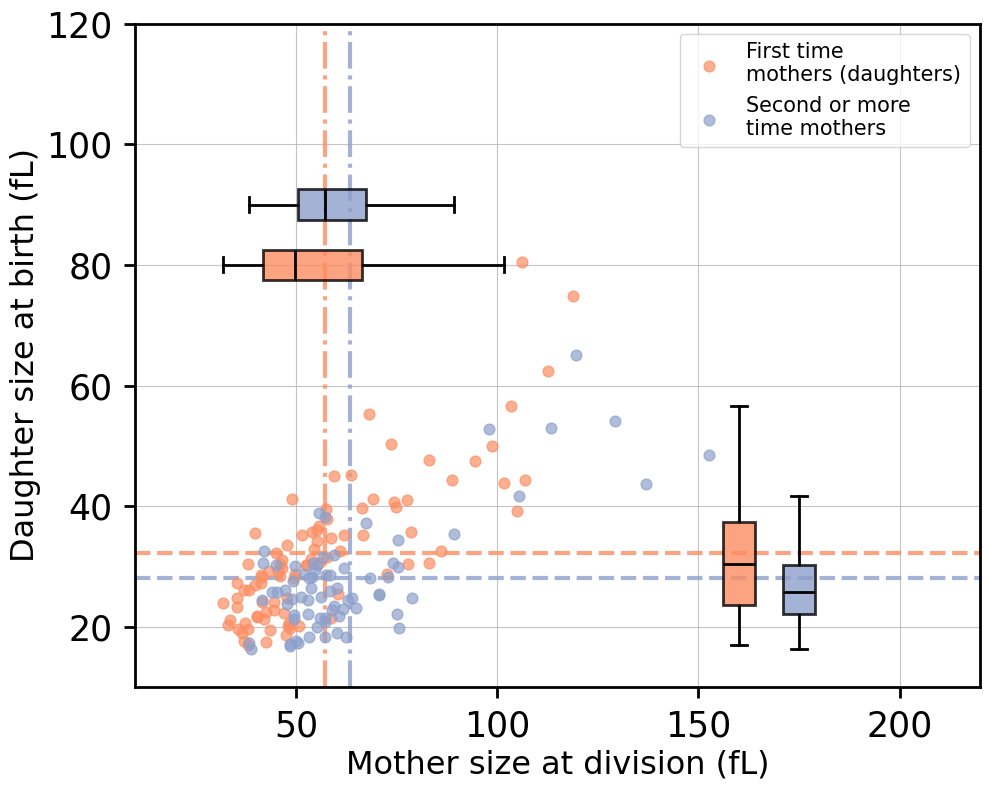

In [91]:
f, ax = plt.subplots(1,1,figsize=(10,8),tight_layout=1)
ax = set_axes(ax)



for i in range(len(mother_subhist)):

    if len(birth_subhist[i]) == 0:
        continue
        
    if mutant == 'cln3':
        bp_pos = [90,210]
        bp_space = [12,18]
        bp_width = [6,10]
        xlim = [40,280]
        ylim = [10,140]
    elif mutant == 'cln3whi5':
        bp_pos = [80,160]
        bp_space = [10,15]
        bp_width = [5,8]
        xlim = [10,220]
        ylim = [10,120]
    mother_div_plot = np.array(mother_div_subhist[i])
    daughter_birth_plot = np.array(birth_subhist[i])
    
    
    if agg:
        if i == 0:
            i_label = 'First time\nmothers (daughters)'
        else:
            i_label = 'Second or more\ntime mothers'
    else:
        i_label = '%i-th time mothers, N = %i'%(i+1,len(birth_subhist[i]))
    ax.scatter(mother_div_plot,daughter_birth_plot,facecolor=colors[min(len(colors)-1,i+1)],s=60,alpha=0.7,zorder=3,label=i_label)
    
    ax.axhline(np.mean(daughter_birth_plot),color=colors[min(len(colors)-1,i+1)],lw=3,ls='--',alpha=0.8,zorder=2)
    ax.axvline(np.mean(mother_div_plot),color=colors[min(len(colors)-1,i+1)],lw=3,ls='-.',alpha=0.8,zorder=2)

    ax.boxplot(mother_div_subhist[i],positions=[bp_pos[0]+bp_space[0]*i],vert=0,widths=bp_width[0],showfliers=0,showmeans=0,showcaps=1,
              patch_artist=True,boxprops=dict(facecolor=colors[i+1],color='k',alpha=0.8,lw=2,zorder=4),
             medianprops = dict(color='k',lw=2,zorder=4),whiskerprops = dict(color='k',lw=2),capprops=dict(lw=2,zorder=4))
    
    ax.boxplot(birth_subhist[i],positions=[bp_pos[1]+bp_space[1]*i],vert=1,widths=bp_width[1],showfliers=0,showmeans=0,showcaps=1,
              patch_artist=True,boxprops=dict(facecolor=colors[i+1],color='k',alpha=0.8,lw=2,zorder=4),
             medianprops = dict(color='k',lw=2,zorder=4),whiskerprops = dict(color='k',lw=2),capprops=dict(lw=2,zorder=4))

    
ax.set_xticks(np.arange(0,501,50))
ax.set_yticks(np.arange(0,501,20))

ax.set_xticklabels(np.arange(0,501,50))
ax.set_yticklabels(np.arange(0,501,20))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('Mother size at division (fL)',fontsize=ax_fontdict['size']-2)
ax.set_ylabel('Daughter size at birth (fL)',fontsize=ax_fontdict['size']-2)

ax.legend(fontsize=ax_fontdict['size']-10)
plt.grid(alpha=0.75,zorder=0)
#if agg:
#    plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'_daughter_birth_vs_mother_division_subpopulations.png'),dpi=450)
#else:
#    plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'_daughter_birth_vs_mother_division_subpopulations_nonagg.png'),dpi=450)
plt.show()

## Asymmetry between first and second time mothers vs. their offspring size

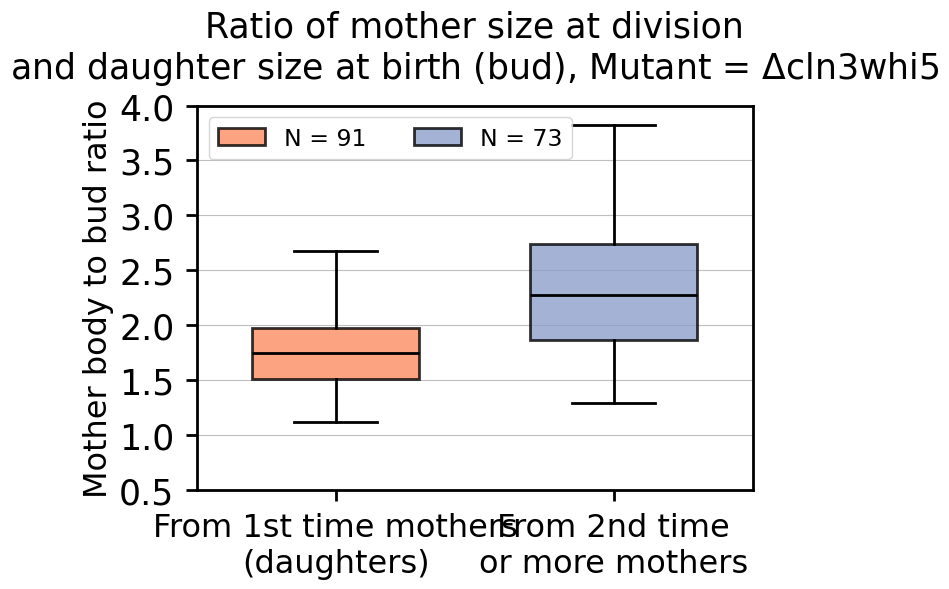

In [92]:
f, ax = plt.subplots(1,1,figsize=(7,6),tight_layout=1)

ax = set_axes(ax)

bp_label = []
bp_patch = []
x_ticklabels = []

for i in range(len(mother_div_subhist)):
    if len(mother_div_subhist[i]) == 0:
        continue
    ncell = len(mother_div_subhist[i])
    asymmetry = np.divide(mother_div_subhist[i],birth_subhist[i])

    bp_label.append(('N = '+str(ncell)))
    bp_patch.append(mpl.patches.Patch(facecolor=colors[i+1],alpha=0.8,edgecolor='k',lw=2,)) 
    
    if agg:
        if i == 0:
            x_ticklabels.append('From 1st time mothers\n(daughters)')
        else:
            x_ticklabels.append('From 2nd time\nor more mothers')
    else:
        x_ticklabels.append('%i gen.'%(i+1))
    
    ax.boxplot(asymmetry,positions=[i],vert=1,widths=0.6,showfliers=0,showmeans=0,showcaps=1,
              patch_artist=True,boxprops=dict(facecolor=colors[i+1],color='k',alpha=0.8,lw=2),
             medianprops = dict(color='k',lw=2),whiskerprops = dict(color='k',lw=2),capprops=dict(lw=2))

ax.set_ylabel('Mother body to bud ratio',fontsize=ax_fontdict['size']-2)

ax.set_yticks(np.arange(0.5,4.1,0.5))

ax.set_xticklabels(x_ticklabels,rotation=0,fontsize=ax_fontdict['size']-2)

ax.set_title('Ratio of mother size at division\nand daughter size at birth (bud), Mutant = $\Delta$%s'%mutant,
             fontsize=ax_fontdict['size'],pad = 20)
ax.legend(bp_patch,bp_label,loc='best',fontsize=ax_fontdict['size']-8,ncol=2)


ax.grid(axis='y',alpha=0.8,zorder=0)
#if agg:
#    plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'_asymmetry_ratio_subpopulations.png'),dpi=450)    
#else:
#    plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'_asymmetry_ratio_subpopulations_nonagg.png'),dpi=450)
plt.show()

## G1 length for 1st gen. daughter cells 

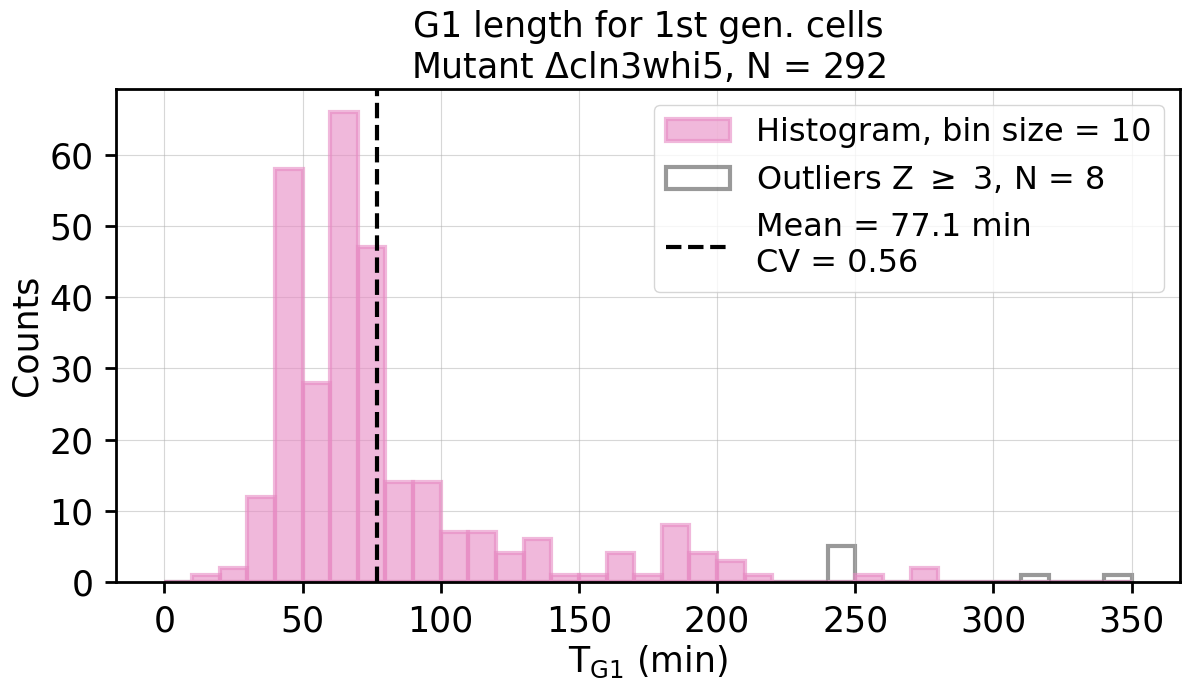

In [93]:
mask = 1
z_thresh = 3
daughter_g1_length_plot = []
g1_length_outliers = []
if mask:
    for iexp, experiment in enumerate(experiments):
        g1_length_outliers.append([])
        z_scores = (np.array(daughter_g1_length[iexp])-np.mean(daughter_g1_length[iexp]))/np.std(daughter_g1_length[iexp])
        daughter_g1_length_plot.extend(np.array(daughter_g1_length[iexp])[np.where(z_scores<z_thresh)])
        g1_length_outliers[iexp]= np.array(daughter_g1_length[iexp])[np.where(z_scores>=z_thresh)].tolist()
    
    daughter_g1_length_plot=np.array(daughter_g1_length_plot)
else:
    daughter_g1_length_plot = np.array(np.concatenate(daughter_g1_length))

ncell = len(daughter_g1_length_plot)

bs=10
bins = np.arange(0,351,bs)
x_plot = np.arange(0,351,1)

bw=10
kde = KernelDensity(kernel='gaussian',bandwidth=bw).fit(np.array(daughter_g1_length_plot).reshape(-1,1))
log_dens = kde.score_samples(x_plot.reshape(-1,1))

mean_daughter_g1_length = np.mean(daughter_g1_length_plot)
std_daughter_g1_length = np.std(daughter_g1_length_plot)
cv_daughter_g1_length = std_daughter_g1_length/mean_daughter_g1_length

f, ax = plt.subplots(1,1,figsize=(12,7),tight_layout=0)
ax = set_axes(ax)

plt.hist(daughter_g1_length_plot,bins=bins,density=0,facecolor=colors[3],edgecolor=colors[3],lw=3,alpha=0.6,zorder=2,label='Histogram, bin size = %i'%bs)
if mask:
    plt.hist(np.concatenate(g1_length_outliers),bins=bins,density=0,facecolor='w',edgecolor='k',lw=3,alpha=0.4,
             zorder=1,label='Outliers Z $\geq$ %s, N = %i'%(str(z_thresh),int(len(np.concatenate(g1_length_outliers)))))
ax.axvline(mean_daughter_g1_length,ls='--',lw=3,color='k',label='Mean = %.1f min \nCV = %.2f'%(mean_daughter_g1_length,cv_daughter_g1_length))
#ax.plot(x_plot.reshape(-1,1),np.exp(log_dens),lw=3,color='r',label='KDE, bw = %.f'%bw)

#ax.set_xlim([0,250])
#ax.set_ylim([0,0.03])
ax.set_ylabel('Counts',fontsize = ax_fontdict['size'])
#ax.set_yticks([0,0.01,0.02,0.03,0.04])
ax.set_xlabel(r'$\rm T_{G1}$ (min)',fontsize = ax_fontdict['size'])
plt.grid(alpha=0.5,zorder=1)

ax.set_title('G1 length for 1st gen. cells\nMutant $\Delta$%s, N = %i'%(mutant,ncell)
             ,fontsize = ax_fontdict['size'],pad=ax_fontdict['pad'])

plt.legend(fontsize = ax_fontdict['size']-2)
#if mask:
#    plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'_g1_length_daughters_zscore_%s.png'%str(z_thresh)),dpi=450)
#else:
#    plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'_g1_length_daughters.png'),dpi=450)
plt.show()

## Estimate of cell size control

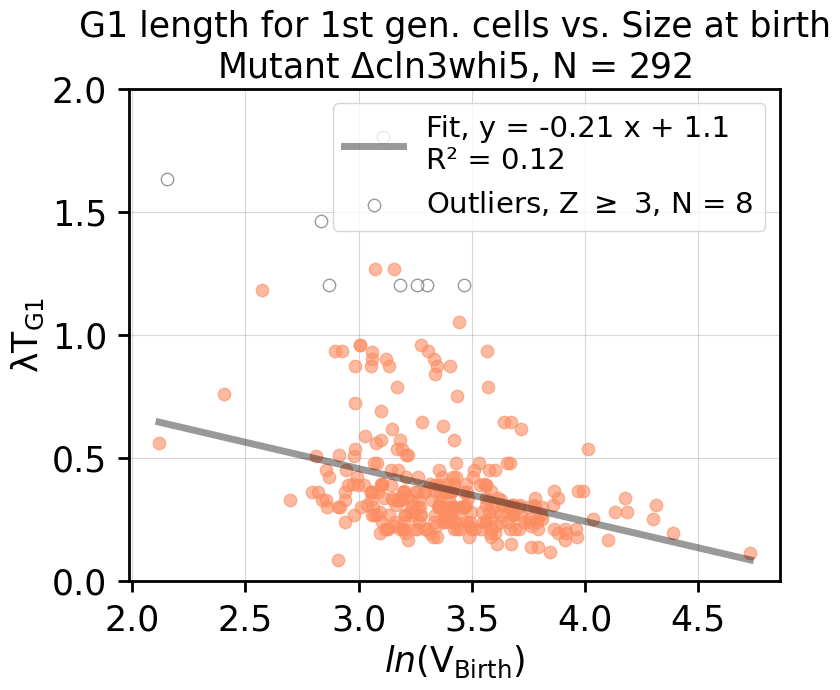

In [94]:
mask = 1
z_thresh = 3
daughter_g1_length_plot = []
first_gen_vol_birth_plot = []
g1_length_outliers = []
vol_birth_outliers = []
if mask:
    for iexp, experiment in enumerate(experiments):
        g1_length_outliers.append([])
        vol_birth_outliers.append([])
        z_scores = (np.array(daughter_g1_length[iexp])-np.mean(daughter_g1_length[iexp]))/np.std(daughter_g1_length[iexp])
        
        temp_daughter_g1_length_plot = np.array(daughter_g1_length[iexp])[np.where(z_scores<z_thresh)]
        first_gen_vol_birth_plot.extend(np.array(first_gen_vol_birth[iexp])[np.where(z_scores<z_thresh)])
        
        g1_length_outliers[iexp]= np.array(daughter_g1_length[iexp])[np.where(z_scores>=z_thresh)].tolist()
        vol_birth_outliers[iexp]= np.array(first_gen_vol_birth[iexp])[np.where(z_scores>=z_thresh)].tolist()
        
        ## GROWTH RATE
        X, Y = np.array(first_gen_g1_growth_smooth_vol[iexp]).reshape(-1,1), np.array(first_gen_g1_growth[iexp]).reshape(-1,1)
        regr_gr = linear_model.LinearRegression(fit_intercept=False)
        # Train the model using the training sets
        regr_gr.fit(X,Y)
        # Make predictions using the testing set
        x_plot = np.linspace(np.amin(X),np.amax(X),50).reshape(-1,1)
        y_plot = regr_gr.predict(x_plot)
        slope = regr_gr.coef_[0][0]
        #intercept = regr.intercept_[0]
        score = regr_gr.score(X, Y)
        ######
        g1_growth_rate=np.log(slope+1)/framerate

        daughter_g1_length_plot.extend(np.multiply(temp_daughter_g1_length_plot,g1_growth_rate))
        g1_length_outliers[iexp] = np.multiply(g1_length_outliers[iexp],g1_growth_rate)
    
    daughter_g1_length_plot = np.array(daughter_g1_length_plot)
    first_gen_vol_birth_plot = np.array(first_gen_vol_birth_plot)
else:
    daughter_g1_length_plot = np.array(np.concatenate(daughter_g1_length))
    first_gen_vol_birth_plot = np.array(np.concatenate(first_gen_vol_birth))
    
    ## GROWTH RATE
    X, Y = np.array(np.concatenate(first_gen_g1_growth_smooth_vol)).reshape(-1,1), np.array(np.concatenate(first_gen_g1_growth[iexp])).reshape(-1,1)
    regr_gr = linear_model.LinearRegression(fit_intercept=False)
    # Train the model using the training sets
    regr_gr.fit(X,Y)
    # Make predictions using the testing set
    x_plot = np.linspace(np.amin(X),np.amax(X),50).reshape(-1,1)
    y_plot = regr_gr.predict(x_plot)
    slope = regr_gr.coef_[0][0]
    #intercept = regr.intercept_[0]
    score = regr_gr.score(X, Y)
    ######
    g1_growth_rate=np.log(slope+1)/framerate
    
    daughter_g1_length_plot = np.multiply(daughter_g1_length_plot,g1_growth_rate)

ncell = len(daughter_g1_length_plot)
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(np.log(first_gen_vol_birth_plot).reshape(-1,1), np.array(daughter_g1_length_plot).reshape(-1,1))

# Make predictions using the testing set
x_plot = np.linspace(min(np.log(first_gen_vol_birth_plot)),max(np.log(first_gen_vol_birth_plot)),50).reshape(-1,1)
y_plot = regr.predict(x_plot)
slope = regr.coef_[0][0]
intercept = regr.intercept_[0]
score = regr.score(np.log(first_gen_vol_birth_plot).reshape(-1,1),  np.array(daughter_g1_length_plot).reshape(-1,1))

f, ax = plt.subplots(1,1,figsize=(8,7),tight_layout=1)
ax=set_axes(ax)

ax.scatter(np.log(first_gen_vol_birth_plot),daughter_g1_length_plot,color=colors[1],s=80,zorder=2,alpha=0.6)

ax.plot(x_plot,y_plot,lw=5,alpha=0.4,color='k',label='Fit, y = %.2f x + %.1f\nR² = %.2f'%(slope,intercept,score))
if mask:
    ax.scatter(np.log(np.concatenate(vol_birth_outliers)),np.concatenate(g1_length_outliers),s=80,facecolor='w',edgecolor='k',alpha=0.4,zorder=1,
              label='Outliers, Z $\geq$ %s, N = %i'%(str(z_thresh),int(len(np.concatenate(g1_length_outliers)))))
ax.set_ylabel(r'$\rm \lambda T_{G1}$',size = ax_fontdict['size'])
ax.set_ylim(0,2)
#ax.set_yticks([0,100,200,300])
ax.set_xlabel(r'$ln(\rm V_{Birth})$',fontsize = ax_fontdict['size'])
plt.grid(alpha=0.5,zorder=1)

ax.set_title('G1 length for 1st gen. cells vs. Size at birth\nMutant $\Delta$%s, N = %i'%(mutant,ncell)
             ,fontsize = ax_fontdict['size'],pad=ax_fontdict['pad'])

plt.legend(fontsize = ax_fontdict['size']-4)
plt.grid(alpha=0.5,zorder=1)
#if mask:
#    plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'lambda_g1_length_daughter_vs_size_birth_mask_zscore_%s.png'%str(z_thresh)),dpi=450)
#else:
#    plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'lambda_g1_length_daughter_vs_size_birth.png'),dpi=450)
plt.show()

## Return map of the G1/S volume at gen. N+1 as a function of the same qty at gen N, conditioned on the age of the N-th generation.

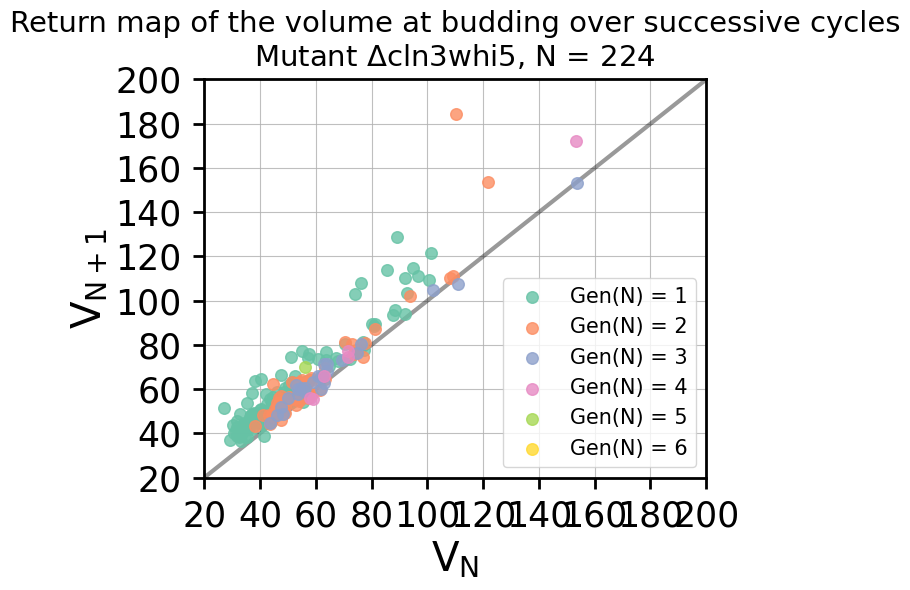

In [95]:
x_plot = np.arange(20,211,1)
mean_size = np.mean(np.concatenate(first_gen_vol_g1_s))
ncell = len(np.concatenate(return_map_n))
y_timer = x_plot
#y_adder = 
#y_sizer = 


f, ax = plt.subplots(1,1,figsize=(7,6),tight_layout=1)
ax1 = set_axes(ax)

flag = 0
gen = 1
while flag == 0:
    gen_indices = np.where(np.array(np.concatenate(return_map_gen_n))==gen)
    if len(gen_indices[0]) == 0:
        flag = 1
    V_n = np.array(np.concatenate(return_map_n))[gen_indices]
    V_np1 = np.array(np.concatenate(return_map_np1))[gen_indices]
    ax1.scatter(V_n,V_np1,s=70,color=colors[gen-1],alpha=0.8,zorder=3,label='Gen(N) = %i'%gen)
    gen += 1
    
ax1.plot(x_plot,y_timer,c='k',lw=3,alpha=0.4,zorder=2)

ax1.set_xlabel(r'$\rm V_{N}$',fontsize=ax_fontdict['size']+4)
ax1.set_ylabel(r'$\rm V_{N+1}$',fontsize=ax_fontdict['size']+4)

ax1.set_xticks(np.arange(0,201,20))
ax1.set_yticks(np.arange(0,201,20))
ax1.set_xlim([20,200])
ax1.set_ylim([20,200])

ax1.legend(loc='lower right',fontsize=ax_fontdict['size']-10,ncol=1)

ax1.grid(axis='both',alpha=0.8,zorder=1)

ax1.set_title('Return map of the volume at budding over successive cycles\nMutant $\Delta$%s, N = %i'%(mutant,ncell),
              fontsize=ax_fontdict['size']-4, pad = 10)

#plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'return_map_volume_g1_s.png'),dpi=450)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Mutant_summary/cln3whi5/cln3whi5volume_g1_s_generations_boxplot.png'

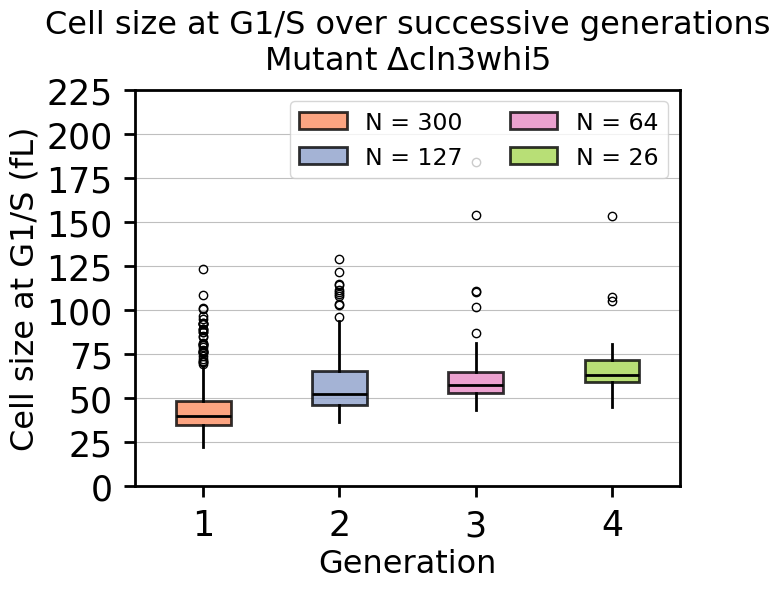

In [96]:
vg1s_all = {}
for iexp, experiment in enumerate(experiments):
    if experiment == "230811_FPG_JK94":
        max_pos = 9
    elif experiment == "230822_JX_JK93":
        max_pos = 8
    elif experiment == "230823_FPG_JK93":
        max_pos = 11
    elif experiment == "230830_FPG_JK94":
        max_pos = 7
    else:
        max_pos = 1
    for pos in range(1,max_pos+1):
        for i,ID in enumerate(analysis_dict[experiment]['Position_'+str(pos)].keys()):
            for j,gen in enumerate(analysis_dict[experiment]['Position_'+str(pos)][ID].keys()):
                if gen not in vg1s_all.keys():
                    vg1s_all[gen] = []

                if 'Volume_G1_S' in analysis_dict[experiment]['Position_'+str(pos)][ID][gen].keys():
                    vg1s_all[gen].append(analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Volume_G1_S'])

f, ax  = plt.subplots(1,1,figsize=(7,6),tight_layout=1)
ax = set_axes(ax)

bp_label = []
bp_patch = []
for igen,gen in enumerate(vg1s_all.keys()):
    ncell = len(vg1s_all[gen])
    if ncell > 8:
        globals()['bp'+str(igen)] = ax.boxplot(vg1s_all[gen],positions=[igen],vert=True,widths=0.4,showfliers=1,showmeans=0,showcaps=0,
            patch_artist=True,boxprops=dict(facecolor=colors[igen],color='k',alpha=0.8,lw=2),
             medianprops = dict(color='k',lw=2),whiskerprops = dict(color='k',lw=2))
        bp_label.append(('N = '+str(ncell)))
        bp_patch.append(mpl.patches.Patch(facecolor=colors[igen],alpha=0.8,edgecolor='k',lw=2,))        
ax.legend(bp_patch,bp_label,loc='best',fontsize=ax_fontdict['size']-8,ncol=2)

ax.set_ylabel('Cell size at G1/S (fL)',fontsize = ax_fontdict['size']-2)
ax.set_xlabel('Generation',fontsize = ax_fontdict['size']-2)
ax.set_yticks(np.arange(0,301,25))
ax.set_ylim(0,225)
ax.set_title('Cell size at G1/S over successive generations\nMutant $\Delta$%s'%(mutant),fontsize=ax_fontdict['size']-2,pad=15)
ax.grid(axis='y',alpha=0.8)

plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'volume_g1_s_generations_boxplot.png'),dpi=450)

plt.show()

## Added volume in G1 for first gen daughter cells

In [ ]:
z_scores = (np.array(np.concatenate(first_gen_vol_birth))-np.mean(np.concatenate(first_gen_vol_birth)))/np.std(np.concatenate(first_gen_vol_birth))

mask = 1
z_thresh = 3
if mask:
    first_gen_vol_birth_plot = np.array(np.concatenate(first_gen_vol_birth))[np.where(z_scores<z_thresh)]
    first_gen_vol_g1_s_plot = np.array(np.concatenate(first_gen_vol_g1_s))[np.where(z_scores<z_thresh)]
else:
    first_gen_vol_birth_plot = np.array(np.concatenate(first_gen_vol_birth))
    first_gen_vol_g1_s_plot = np.array(np.concatenate(first_gen_vol_g1_s))
    
ncell = len(first_gen_vol_birth_plot)
X = np.array(first_gen_vol_birth_plot).reshape(-1,1)
Y = np.array(first_gen_vol_g1_s_plot).reshape(-1,1) - np.array(first_gen_vol_birth_plot).reshape(-1,1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, Y)

# Make predictions using the testing set
x_plot = np.linspace(np.amin(X),np.amax(X))
y_plot = regr.predict(x_plot.reshape(-1,1))
slope = regr.coef_[0][0]
intercept = regr.intercept_[0]
score = regr.score(X,Y)

# Binned Statistics 
n_bins = 5
bin_std, bin_edges, binnumber = stats.binned_statistic(first_gen_vol_birth_plot,first_gen_vol_g1_s_plot-first_gen_vol_birth_plot,statistic='std', bins=n_bins)
bin_means, bin_edges, binnumber = stats.binned_statistic(first_gen_vol_birth_plot,first_gen_vol_g1_s_plot-first_gen_vol_birth_plot,statistic='mean', bins=n_bins)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2


f,ax = plt.subplots(1,1,figsize=(7,6),tight_layout=1)
ax=set_axes(ax)

ax.scatter(X,Y,s=60,color=colors[1],alpha=0.3,zorder=2,)
if mask:
    ax.scatter(np.array(np.concatenate(first_gen_vol_birth))[np.where(z_scores>=z_thresh)],
               np.array(np.concatenate(first_gen_vol_g1_s))[np.where(z_scores>=z_thresh)]-np.array(np.concatenate(first_gen_vol_birth))[np.where(z_scores>=z_thresh)],
               facecolor="gray",alpha=0.4,edgecolor='k',s=80,zorder=1,label='Outliers, Z $\geq$ %s'%str(z_thresh))

ax.errorbar(bin_centers,bin_means,yerr=bin_std,capsize=4,capthick=3,c=colors[1],lw=3,zorder=3,alpha=1,label=r'Binned means $\pm \sigma$')  
   
ax.plot(x_plot,y_plot,lw=3,color='k',alpha=0.8,zorder=4,label='Fit, y = %.2fx + %.1f\nR² = %.2f'%(slope,intercept,score))

ax.set_xlabel(r'$\rm V_{Birth}$',fontsize=ax_fontdict['size'])
ax.set_ylabel(r'$\rm \Delta V_{G1}$',fontsize=ax_fontdict['size'])

#ax.set_xticks(np.arange(0,101,10))
ax.set_yticks(np.arange(0,201,25))

#ax.set_xlim(0,90)
ax.set_ylim(-20,150)

ax.set_title('Added volume in G1 for first gen. daughter cells\nMutant $\Delta$%s, N = %i'%(mutant,ncell),
            fontsize=ax_fontdict['size']-4,pad=10)

plt.legend(fontsize=ax_fontdict['size']-10,ncol=1)
plt.grid(which='both',alpha=0.8)

#plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'added_volume_G1.png'),dpi=450)

plt.show()

## Time in G1 for 2nd generation or later mother cells

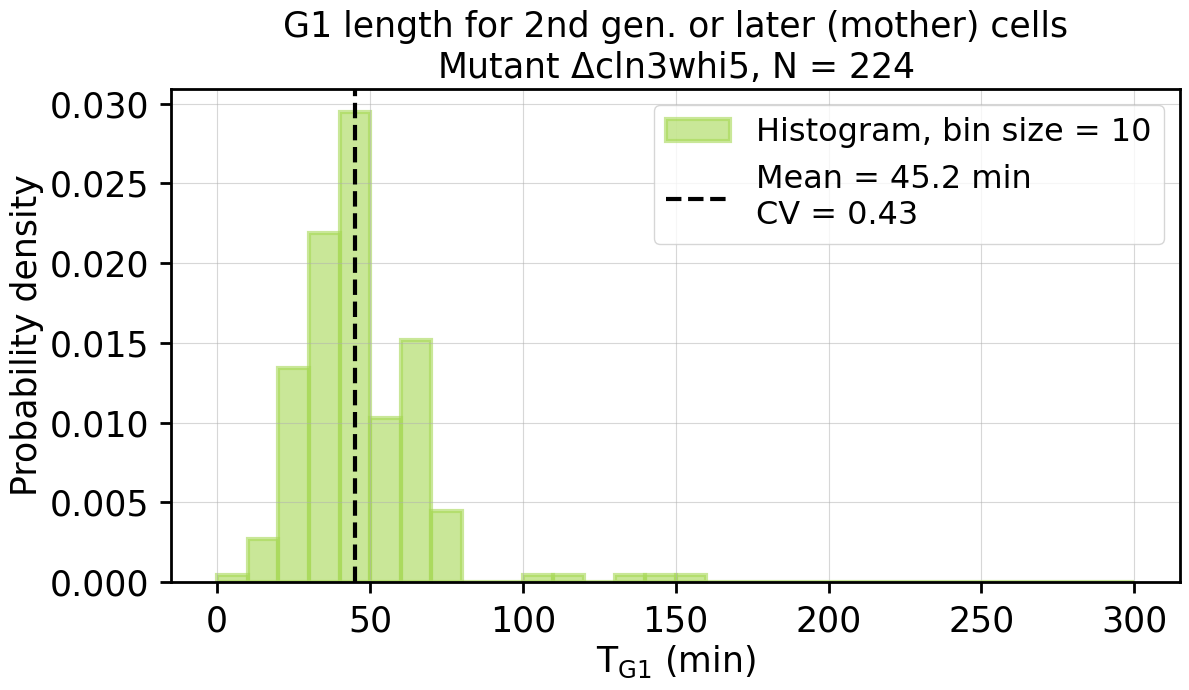

In [97]:
ncell = len(np.concatenate(mother_g1_length))

bs=10
bins = np.arange(0,301,bs)
x_plot = np.arange(0,301,1)

bw=10
kde = KernelDensity(kernel='gaussian',bandwidth=bw).fit(np.array(np.concatenate(mother_g1_length)).reshape(-1,1))
log_dens = kde.score_samples(x_plot.reshape(-1,1))

mean_mother_g1_length = np.mean(np.concatenate(mother_g1_length))
std_mother_g1_length = np.std(np.concatenate(mother_g1_length))
cv_mother_g1_length = std_mother_g1_length/mean_mother_g1_length

f, ax = plt.subplots(1,1,figsize=(12,7),tight_layout=0)
ax = set_axes(ax)

plt.hist(np.concatenate(mother_g1_length),bins=bins,density=1,facecolor=colors[4],edgecolor=colors[4],lw=3,alpha=0.6,label='Histogram, bin size = %i'%bs)
ax.axvline(mean_mother_g1_length,ls='--',lw=3,color='k',label='Mean = %.1f min \nCV = %.2f'%(mean_mother_g1_length,cv_mother_g1_length))
#ax.plot(x_plot.reshape(-1,1),np.exp(log_dens),lw=3,color='r',label='KDE, bw = %.f'%bw)

#ax.set_xlim([0,250])
#ax.set_ylim([0,0.03])
ax.set_ylabel('Probability density',fontsize = ax_fontdict['size'])
#ax.set_yticks([0,0.01,0.02,0.03,0.04])
ax.set_xlabel(r'$\rm T_{G1}$ (min)',fontsize = ax_fontdict['size'])
plt.grid(alpha=0.5,zorder=1)

ax.set_title('G1 length for 2nd gen. or later (mother) cells\nMutant $\Delta$%s, N = %i'%(mutant,ncell)
             ,fontsize = ax_fontdict['size'],pad=ax_fontdict['pad'])

plt.legend(fontsize = ax_fontdict['size']-2)

#plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'_g1_length_mothers.png'),dpi=450)
plt.show()

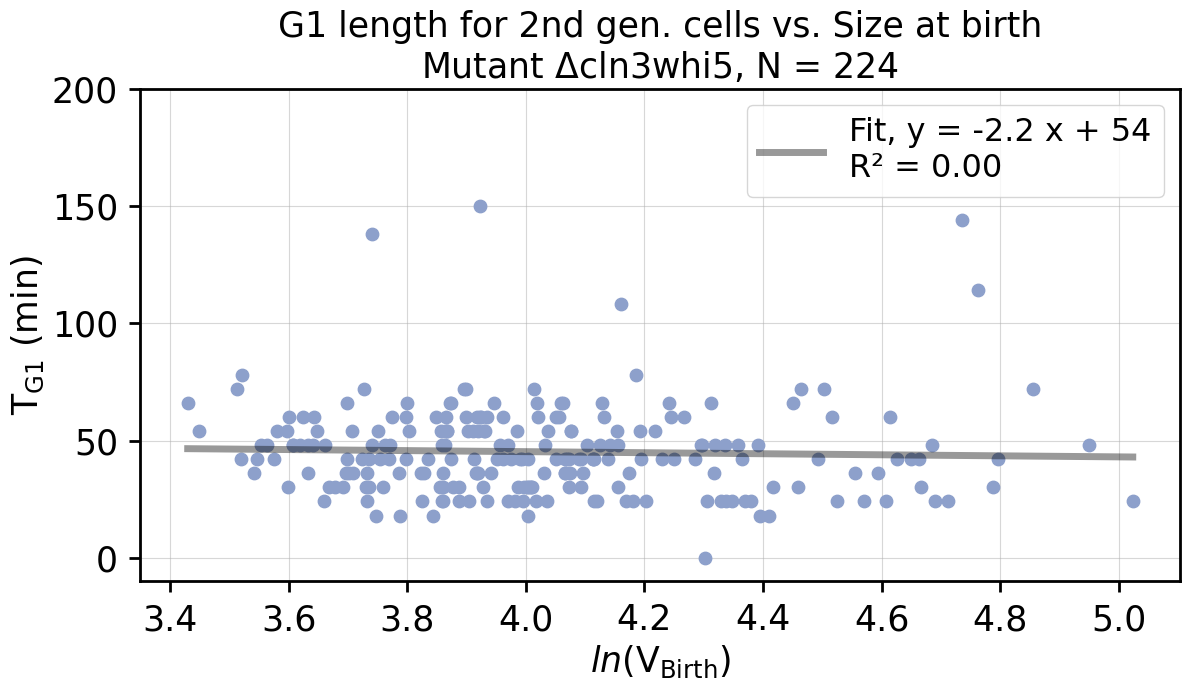

In [98]:
ncell = len(np.concatenate(mother_g1_length))
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(np.log(np.concatenate(mother_vol_birth)).reshape(-1,1), np.array(np.concatenate(mother_g1_length)).reshape(-1,1))

# Make predictions using the testing set
x_plot = np.linspace(min(np.log(np.concatenate(mother_vol_birth))),max(np.log(np.concatenate(mother_vol_birth))),50).reshape(-1,1)
y_plot = regr.predict(x_plot)
slope = regr.coef_[0][0]
intercept = regr.intercept_[0]
score = regr.score(np.log(np.concatenate(mother_vol_birth)).reshape(-1,1),  np.array(np.concatenate(mother_g1_length)).reshape(-1,1))


f, ax = plt.subplots(1,1,figsize=(12,7),tight_layout=1)
ax=set_axes(ax)

ax.scatter(np.log(np.concatenate(mother_vol_birth)),np.concatenate(mother_g1_length),color=colors[2],s=80,zorder=2)

ax.plot(x_plot,y_plot,lw=5,alpha=0.4,color='k',label='Fit, y = %.1f x + %.f\nR² = %.2f'%(slope,intercept,score))

ax.set_ylabel(r'$\rm T_{G1}$ (min)',size = ax_fontdict['size'])
ax.set_yticks([0,50,100,150,200,300])
ax.set_ylim(-10,200)
ax.set_xlabel(r'$ln(\rm V_{Birth})$',fontsize = ax_fontdict['size'])
plt.grid(alpha=0.5,zorder=1)

ax.set_title('G1 length for 2nd gen. cells vs. Size at birth\nMutant $\Delta$%s, N = %i'%(mutant,ncell)
             ,fontsize = ax_fontdict['size'],pad=ax_fontdict['pad'])

plt.legend(fontsize = ax_fontdict['size']-2)
plt.grid(alpha=0.5,zorder=1)

#plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'_g1_length_mother_vs_size_birth.png'),dpi=450)
plt.show()

___
## Plot all cells volume at the last frame of the movies
___

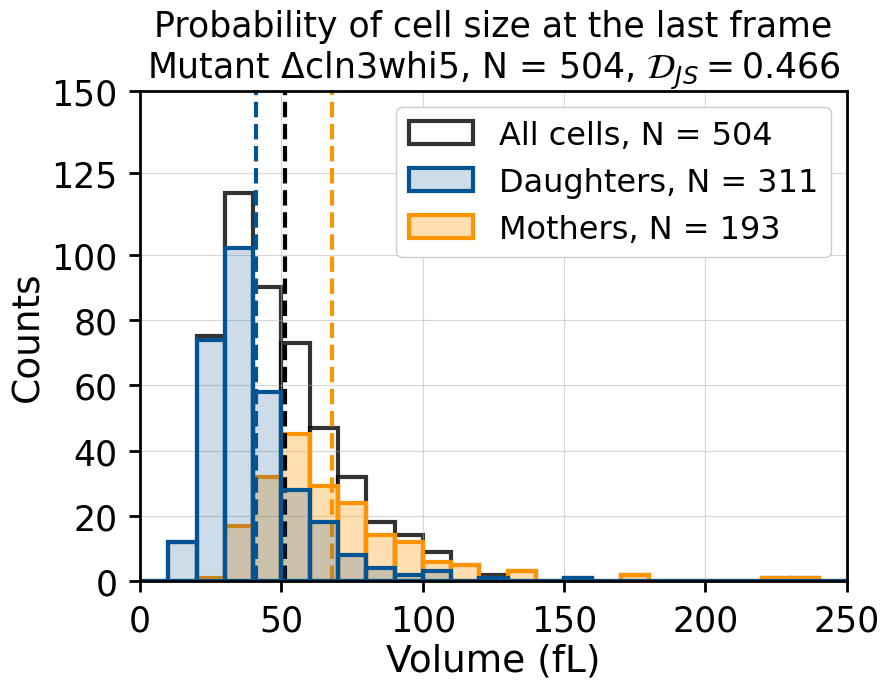

In [99]:
#Remove outliers if any?
trunk = 0
if trunk:
    outliers = np.where(np.array(np.concatenate(end_vol))> 200)
    end_cc = np.delete(np.array(np.concatenate(end_cc)),outliers)
    end_gen = np.delete(np.array(np.concatenate(end_gen)),outliers)
    end_vol = np.delete(np.array(np.concatenate(end_vol)),outliers)

daughter_end_vol = np.array(np.concatenate(end_vol))[np.where(np.array(np.concatenate(end_gen)) == 1)]
mother_end_vol = np.array(np.concatenate(end_vol))[np.where(np.array(np.concatenate(end_gen)) != 1)]

ncell = len(np.concatenate(end_vol))
ndaughter = len(daughter_end_vol)
nmother = len(mother_end_vol)

prop_g1 = len(np.array(np.concatenate(end_cc))[np.where(np.array(np.concatenate(end_cc)) == 'G1')])/ncell

bs=10
bins = np.arange(0,251,bs)

mean_end_vol = np.mean(np.concatenate(end_vol))
std_end_vol = np.std(np.concatenate(end_vol))
cv_end_vol = std_end_vol/mean_end_vol

mean_daughter_end_vol = np.mean(daughter_end_vol)
std_daughter_end_vol = np.std(daughter_end_vol)
cv_daughter_end_vol = std_daughter_end_vol/mean_daughter_end_vol

mean_mother_end_vol = np.mean(mother_end_vol)
std_mother_end_vol = np.std(mother_end_vol)
cv_mother_end_vol = std_mother_end_vol/mean_mother_end_vol

p_mothers,edges = np.histogram(mother_end_vol,bins=bins,density=1)
p_daughters,edges = np.histogram(daughter_end_vol,bins=bins,density=1)
jsd = distance.jensenshannon(p_daughters,p_mothers)
#print(jsd)

c_patch_d1_R,c_patch_d1_G,c_patch_d1_B = mpl.colors.to_rgb(new_color_d1)
c_patch_m1_R,c_patch_m1_G,c_patch_m1_B = mpl.colors.to_rgb(new_color_m1)

f, ax = plt.subplots(1,1,figsize=(9,7),tight_layout=0)
ax = set_axes(ax)

plt.hist(np.concatenate(end_vol),histtype='barstacked',bins=bins,density=0,facecolor='w',edgecolor='k',lw=3,alpha=0.8,zorder=1
         ,label='All cells, N = %i'%ncell)
plt.hist(daughter_end_vol,histtype='barstacked',bins=bins,density=0,facecolor=[c_patch_d1_R,c_patch_d1_G,c_patch_d1_B,0.2],edgecolor=[c_patch_d1_R,c_patch_d1_G,c_patch_d1_B,1]
         ,lw=3,zorder=3,label='Daughters, N = %i'%ndaughter)
plt.hist(mother_end_vol,histtype='barstacked',bins=bins,density=0,facecolor=[c_patch_m1_R,c_patch_m1_G,c_patch_m1_B,0.3],edgecolor=[c_patch_m1_R,c_patch_m1_G,c_patch_m1_B,1]
         ,lw=3,zorder=2,label='Mothers, N = %i'%nmother)

ax.axvline(mean_end_vol,ls='--',lw=3,color='k')
ax.axvline(mean_daughter_end_vol,ls='--',lw=3,color=new_color_d1)
ax.axvline(mean_mother_end_vol,ls='--',lw=3,color=new_color_m1)

ax.set_xlim([0,250])

ax.set_ylabel('Counts',fontsize = ax_fontdict['size']+2)
ax.set_yticks([0,20,40,60,80,100,125,150])
ax.set_ylim([0,150.1])
ax.set_xlabel('Volume (fL)',fontsize = ax_fontdict['size']+2)
plt.grid(alpha=0.5,zorder=1)

ax.set_title('Probability of cell size at the last frame\nMutant $\Delta$%s, N = %i, $\mathcal{D}_{JS} = %.3f$'%(mutant,ncell,jsd)
             ,fontsize = ax_fontdict['size'],pad=ax_fontdict['pad'])

plt.legend(fontsize = ax_fontdict['size']-2,ncol=1,framealpha=1)

#plt.savefig(os.path.join("Mutant_summary",mutant,mutant+'_size_last_frame.png'),dpi=450)
plt.show()

___ 
## Logistic regressions and statistical predictors of budding

In [104]:
# Statistical predictors X
logreg_volume = []
logreg_addedvolume = []
logreg_age = []

# Binary cell cycle state Y we predict with statistical predictors X above
logreg_ccb = []

for experiment in experiments:
    if experiment == "230811_FPG_JK94":
        max_pos = 9
    elif experiment == "230822_JX_JK93":
        max_pos = 8
    elif experiment == "230823_FPG_JK93":
        max_pos = 11
    elif experiment == "230830_FPG_JK94":
        max_pos = 7
    else:
        max_pos = 1
    for pos in range(1,max_pos+1):
        for i,ID in enumerate(analysis_dict[experiment]['Position_'+str(pos)].keys()):
            for j,gen in enumerate(analysis_dict[experiment]['Position_'+str(pos)][ID].keys()):
                # First gen cells that have gone through G1/S
                cell_cycle = analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Cell_cycle']
                if gen[-1] == '1' and 'S' in cell_cycle:
                    time_birth = analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Time'][0]
                    volume_birth = analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Volume'][0]
                    
                    G1_index = np.where(cell_cycle=='G1')[0]
                    S_index = np.where(cell_cycle=='S')[0]

                    # What we are trying to predict
                    cell_cycle_binary = []
                    volume = []
                    age = []

                    for icc, cc in enumerate(cell_cycle):
                        if cc == 'G1':
                            cell_cycle_binary.append(0.0)
                            volume.append(analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Volume'][icc])
                            age.append(analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Time'][icc] - time_birth)
                        else:
                            cell_cycle_binary.append(1.0)
                            volume.append(analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Volume'][icc])
                            age.append(analysis_dict[experiment]['Position_'+str(pos)][ID][gen]['Time'][icc] - time_birth)
                            break

                    # Possible predictors
                    logreg_age.extend(age)
    
                    logreg_volume.extend(volume)
                    
                    addedvolume = list(np.subtract(volume,volume_birth))
                    logreg_addedvolume.extend(addedvolume)
                    

                    logreg_ccb.extend(cell_cycle_binary) 

X_age = np.array(logreg_age).reshape(-1,1)
X_volume = np.array(logreg_volume).reshape(-1,1)
X_addedvolume = np.array(logreg_addedvolume).reshape(-1,1)
X_volume_age = np.concatenate((X_volume,X_age),axis=1)
X_full = np.concatenate((X_volume,X_age,X_addedvolume),axis=1)

y_ccb = np.array(logreg_ccb)
         
logisticreg_age = LogisticRegression(penalty=None,solver='newton-cholesky',class_weight='balanced').fit(X_age,y_ccb)           
logisticreg_volume = LogisticRegression(penalty=None,solver='newton-cholesky',class_weight='balanced').fit(X_volume,y_ccb)
logisticreg_addedvolume = LogisticRegression(penalty=None,solver='newton-cholesky',class_weight='balanced').fit(X_addedvolume,y_ccb)
logisticreg_volume_age = LogisticRegression(penalty=None,solver='newton-cholesky',class_weight='balanced').fit(X_volume_age,y_ccb)
logisticreg_full = LogisticRegression(penalty=None,solver='newton-cholesky',class_weight='balanced').fit(X_full,y_ccb)

n_G1 = len(np.where(y_ccb == 0)[0])
n_SG2M = len(np.where(y_ccb == 1)[0])
weight_G1 = (n_G1+n_SG2M)/(2*n_G1)
weight_SG2M = (n_G1+n_SG2M)/(2*n_SG2M)
dummy_weight = np.zeros_like(y_ccb)
dummy_weight[np.where(y_ccb == 0)] = weight_G1
dummy_weight[np.where(y_ccb == 1)] = weight_SG2M


X_dummy = np.zeros(len(y_ccb))
null_model = DummyClassifier(strategy='prior').fit(X_dummy,y_ccb,sample_weight=dummy_weight)

dev_age = deviance(X_age,y_ccb,logisticreg_age) 
dev_volume = deviance(X_volume,y_ccb,logisticreg_volume) 
dev_addedvolume =deviance(X_addedvolume,y_ccb,logisticreg_addedvolume)
dev_volume_age =deviance(X_volume_age,y_ccb,logisticreg_volume_age) 
dev_null = deviance(X_dummy,y_ccb,null_model) 
dev_full = deviance(X_full,y_ccb,logisticreg_full) 
print(dev_null,dev_volume,dev_addedvolume,dev_volume_age,dev_full)

1.3862943611198804 1.362884163384945 1.376917922197585 1.3468489195652669 1.248755335130511
